In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm


from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder

from astropy.stats import mad_std
import time

from lvmtipo.actors import lvm
from lvmagp.focus import Focus


In [2]:
from logging import DEBUG

#from sdsstools.logger import StreamFormatter
#from sdsstools import get_logger, read_yaml_file
#from sdsstools.logger import SDSSLogger

import numpy as np

from astropy.coordinates import SkyCoord, Angle
import astropy.wcs
import astropy.units as u

#from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from scipy.ndimage import median_filter

In [3]:
import asyncio

from cluplus.proxy import invoke

from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

from IPython.display import clear_output

In [4]:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz,ICRS

import astrometry
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={5,6},
    )
)

import spherepoints


In [5]:


import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import colors


from mpl_toolkits.axes_grid1 import make_axes_locatable


from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)


ellipse = lambda c: Ellipse(xy=(c['x'], c['y']),
                            width=8*c['a'],
                            height=8*c['b'],
                            angle=c['theta'] * -180. / np.pi)

def plot_catalog(ax, catalog, color="red", cat_max=8, cat_rest=None):
     for c in catalog[:cat_max]:
         e = ellipse(c)
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)
     if cat_rest:
         for c in catalog[cat_max+1:]:
             e = ellipse(c)
             e.set_facecolor('none')
             e.set_edgecolor("white")
             ax.add_artist(e)

def plot_centroid(ax, catalog, color="white"):
     catalog = catalog.transpose()
     for c in catalog:
         e = ellipse({'x': c[0], 'y': c[1], 'a': 8, 'b': 8, 'theta': 0})
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)

def plot_images(images, vmin=None, vmax=None, rotate=None, cat_max = 8, cat_rest = None, cat_extra=None, figsize=None, wcs=None):
    data = images[0].data
    mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
    lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.5)
    median = np.median(data)

    
    args={}
#    fig, ax = plt.subplots(1, ncols=(len(images)))
#    fig, ax = plt.subplots(1, ncols=(len(images)), dpi=100)
    fig, ax = plt.subplots(1, ncols=(len(images)), figsize=figsize if figsize else (8, 5/len(images)), *args)
#    fig, ax = plt.subplots(nrows=(len(images)), figsize=(16,9))
    
    fig.canvas.toolbar_visible = 'fade-in-fade-out'
#    fig.canvas.footer_visible = False
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'left'
    is_single_image = len(images) > 1


    for idx, img in enumerate(images):
        if rotate and rotate[idx]:
            data = np.copy(img.data).transpose()
        else:
            data = img.data

        ax_idx = ax[idx] if is_single_image else ax
        ax_idx.set_title(img.header["CAMNAME"])
        ax_idx.scatter([img.data.shape[1]/2], [img.data.shape[0]/2], marker='+', s=40, color='red')
#        ax_im = ax_idx.imshow(data,
#                              vmin=vmin if vmin else median,
#                              vmax=vmax if vmax else uperc)
        if wcs: 
            # wcs = WCS(hdu.header)
            print(wcs)

        ax_im = ax_idx.imshow(data,
                              norm=PowerNorm(1.4,
                                             vmin=vmin if vmin else median,
                                             vmax=vmax if vmax else uperc,
                                             clip=True,
                                            )
                             )

        

        ax_idx.invert_yaxis()
        fig.colorbar(ax_im, cax=make_axes_locatable(ax_idx).append_axes('right', size='3%', pad=0.05), orientation='vertical')
      
        if img.catalog:
            plot_catalog(ax_idx, img.catalog, "red", cat_max, cat_rest)

        if cat_extra:
            plot_catalog(ax_idx, cat_extra[idx], "yellow")

        if hasattr(img, "centroid"):
            plot_centroid(ax_idx, img.centroid, "white")

    # plt.scatter(x, y, marker='+', s=40, color='red')

    fig.tight_layout()
    plt.show()
    
from lvmagp.focus.focusseries.base import FocusSeries
from lvmagp.focus.curvefit import fit_hyperbola
from lvmagp.images import Image

import matplotlib.pyplot as plt


def callback(data):
    if isinstance(data[0], Image):
        for idx, img in enumerate(data):
            print(f"cam: {img.header['CAMNAME']} focus: {img.header['FOCUSDT']} srcs: {len(img.catalog)}")
        plot_images(data)
    elif isinstance(data[0], tuple):
        fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(10, 5/len(data)))

        for idx, d in enumerate(data):
            camera = d[0]
            dd = d[1]
            focus = [d["focus"] for d in dd]
            r = [d["r"] for d in dd]
            rerr = [d["rerr"] for d in dd]

            ax_idx = ax[idx] if len(data) > 1 else ax
            ax_idx.set_title(camera)
            ax_idx.errorbar(focus, r, yerr=rerr)

async def foc_series(do_home=False):
    
    if do_home:
        await lvm.skyw.foc.moveToHome()
    
    focvals = await focus.fine(exposure_time=7.0, guess=36.07, count=5, step=0.3, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

    with fits.open(filenames[0]) as hdul:
        data_east = hdul[0].data

    with fits.open(filenames[1]) as hdul:
        data_west = hdul[0].data

    image_list = [data_east,data_west]

    fig,(ax1,ax2) = plt.subplots(figsize=(8,8),ncols=2)
    ax1.imshow(data_east.T,norm=LogNorm(vmin=50, vmax=1000))
    ax2.imshow(data_west.T,norm=LogNorm(vmin=50, vmax=1000))
    fig.suptitle("best focus images")
    plt.show()
    return filenames

async def find_foc(guess=40.):
    focvals = await focus.fine(exposure_time=10.0, guess=guess, count=5, step=0.5, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

In [7]:
# select telescope
tel = lvm.skyw


await tel.start()

focus = Focus(tel)

await tel.foc.status()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': 40.466,
 'DeviceEncoder': {'Position': 233.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False}

In [8]:
plot = False

alt,az = spherepoints.uniform_points(n=240,minimum_alt=30)

az = az[np.flip(np.argsort(alt))]
alt = alt[np.flip(np.argsort(alt))]

#alt = np.array([0.5*np.pi])
#az = np.array([0])

theta = 0.5*np.pi - alt

r = 1

x = r * np.sin( theta) * np.cos( az )
y = r * np.sin( theta) * np.sin( az )
z = r * np.cos(theta)

if plot:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_box_aspect(aspect=(1,1,1))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    #ax.set_aspect("equal")#
    ax.plot(x,y,z,"ko")

959.9999999999998


In [18]:
#await tel.pwi.findHome()
await tel.agc.status()


{'east': {'temperature': 41.875,
  'cooler': nan,
  'binning': [1, 1],
  'area': [1600, 1100],
  'state': 'online'},
 'west': {'temperature': 37.5,
  'cooler': nan,
  'binning': [1, 1],
  'area': [1600, 1100],
  'state': 'online'}}

In [9]:
current_alt = 80./180.*np.pi
current_az = 180./180.*np.pi

observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
observing_time = Time.now()

current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
current_icrs = current_aa.transform_to(ICRS)
print(current_aa)
print(current_icrs)

rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
print(f"ra_h:dec_d {ra_h}:{dec_d}")

<SkyCoord (AltAz: obstime=2023-03-08 01:24:31.843594, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 80.)>
<SkyCoord (ICRS): (ra, dec) in deg
    (115.72527954, -38.94523136)>
ra_h:dec_d 7.71502232903096:-38.9452451892651


cam: east focus: 37.5 srcs: 0
cam: west focus: 37.5 srcs: 0


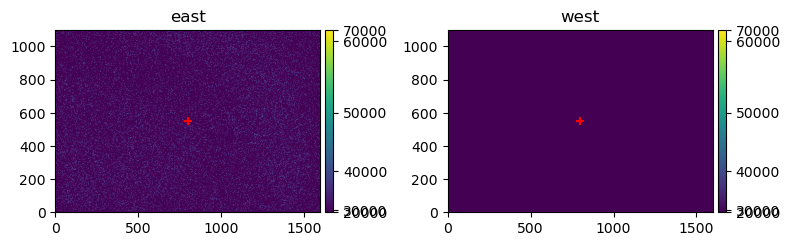

cam: east focus: 38.0 srcs: 6
cam: west focus: 38.0 srcs: 5


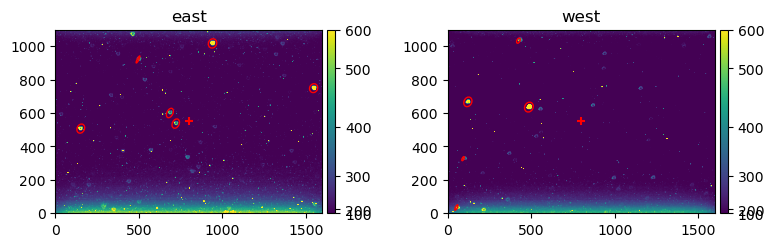

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 12.2+-2.6.


cam: east focus: 38.5 srcs: 7
cam: west focus: 38.5 srcs: 7


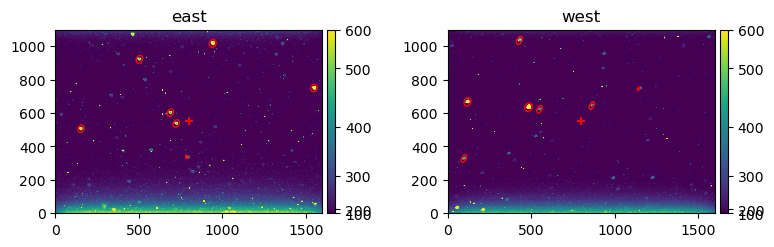

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 9.4+-1.0.


cam: east focus: 39.0 srcs: 11
cam: west focus: 39.0 srcs: 7


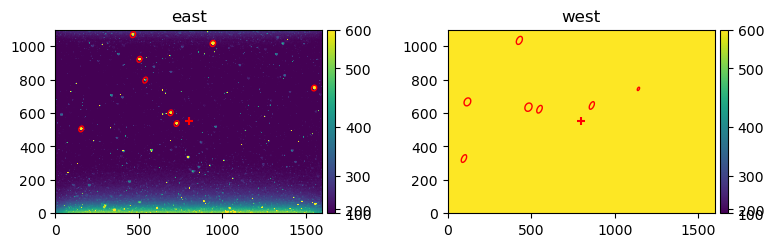

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 5.7+-0.7.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.1+-0.6.


cam: east focus: 39.5 srcs: 25
cam: west focus: 39.5 srcs: 23


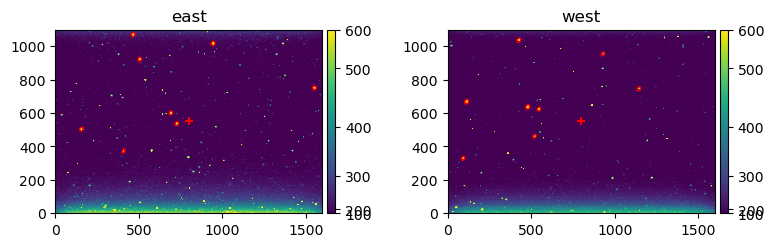

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.7+-0.5.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.0+-0.5.


cam: east focus: 40.0 srcs: 37
cam: west focus: 40.0 srcs: 32


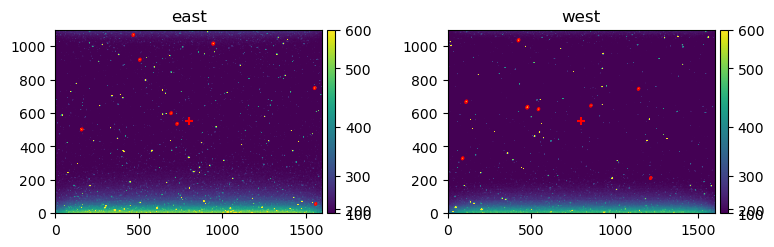

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.3+-0.5.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.7+-0.5.


cam: east focus: 40.5 srcs: 34
cam: west focus: 40.5 srcs: 29


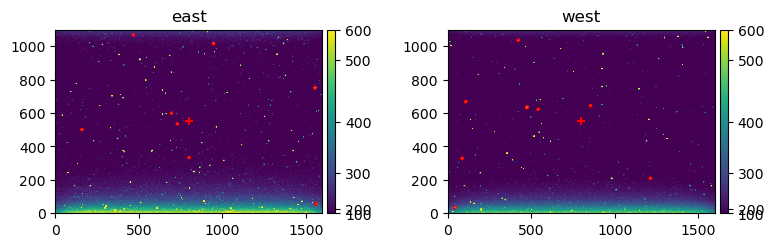

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.8+-0.7.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.4+-0.7.


cam: east focus: 41.0 srcs: 30
cam: west focus: 41.0 srcs: 26


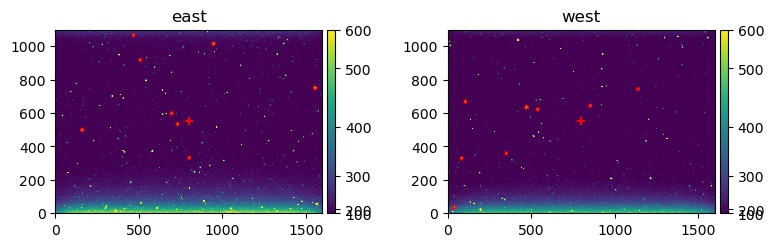

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.0+-1.7.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.3+-1.1.


cam: east focus: 41.5 srcs: 16
cam: west focus: 41.5 srcs: 17


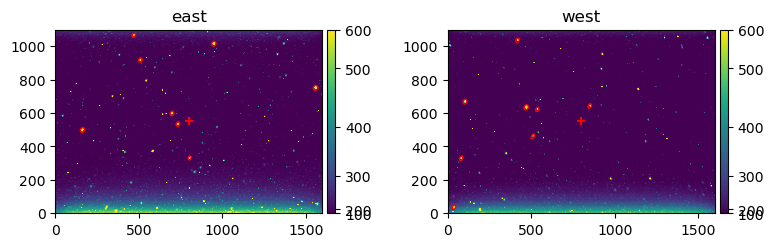

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 8.7+-2.6.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.2+-2.9.


cam: east focus: 42.0 srcs: 9
cam: west focus: 42.0 srcs: 11


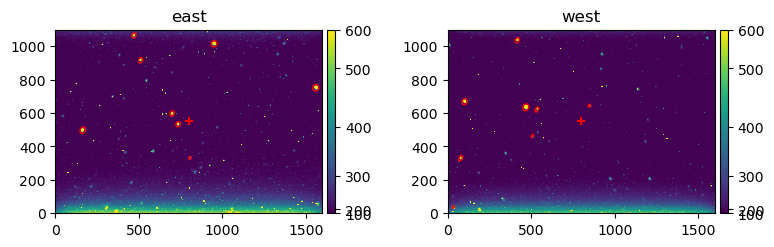

cam: east focus: 42.5 srcs: 7
cam: west focus: 42.5 srcs: 4


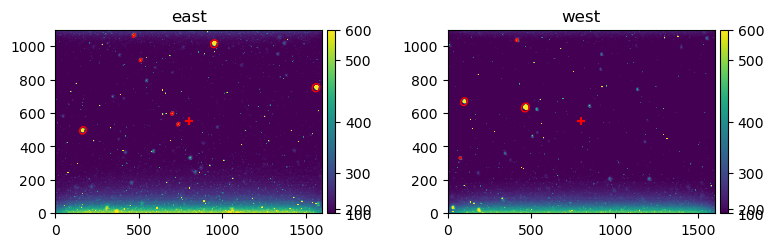

DEBUG:lvm_tel_focus:foc move to position 40.46628045384112 dt


[[4.04674856e+01 3.73548996e-03]
 [4.04650753e+01 3.95618930e-03]]
best focus [4.04662805e+01 3.84583963e-03]
best focus images: ['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000012.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000012.fits']


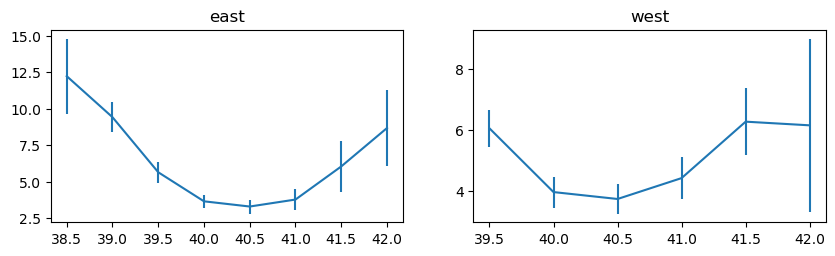

In [20]:
await find_foc()

In [17]:
await tel.km.moveToHome()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': -135.0,
 'DeviceEncoder': {'Position': 0.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': True,
 'CurrentTime': 850098422.0,
 'Simulate': False,
 'SkyPA': -270.0}

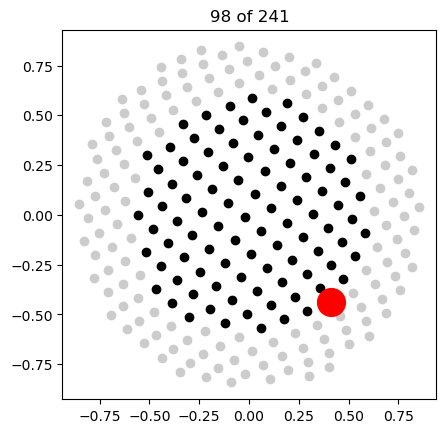

0.9279415065344787 -0.8165930144316603
<SkyCoord (AltAz: obstime=2023-03-08 02:12:18.582910, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (313.21266669, 53.16713196)>
<SkyCoord (ICRS): (ra, dec) in deg
    (101.69559609, -1.63996279)>
ra_h:dec_d 6.77969668441353:-1.63995530849993
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000192.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000146.fits']
---------------------------------


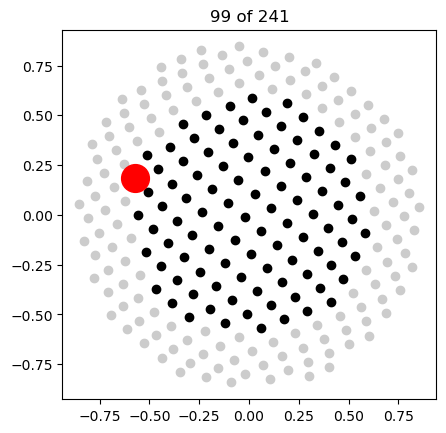

0.9269165157486953 2.8290733619415755
<SkyCoord (AltAz: obstime=2023-03-08 02:12:43.957010, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (162.09396357, 53.10840431)>
<SkyCoord (ICRS): (ra, dec) in deg
    (151.42624806, -62.43062949)>
ra_h:dec_d 10.0950891714035:-62.4307172608146
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000193.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000147.fits']
---------------------------------


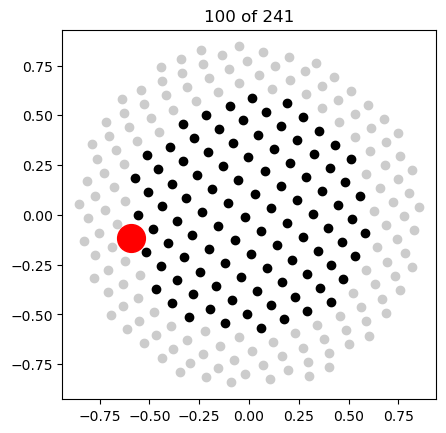

0.9220892002883881 -2.9488188586365554
<SkyCoord (AltAz: obstime=2023-03-08 02:13:06.664824, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (191.04512485, 52.83181951)>
<SkyCoord (ICRS): (ra, dec) in deg
    (112.27417329, -64.76803465)>
ra_h:dec_d 7.48494203143411:-64.7680651792014
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000194.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000148.fits']
---------------------------------


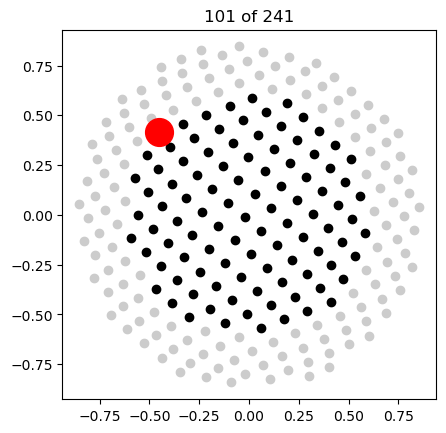

0.9121964916572881 2.398708324941877
<SkyCoord (AltAz: obstime=2023-03-08 02:13:24.058401, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (137.4358633, 52.26500906)>
<SkyCoord (ICRS): (ra, dec) in deg
    (169.09618275, -50.92231297)>
ra_h:dec_d 11.273082419913:-50.9223696015979
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000195.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000149.fits']
---------------------------------


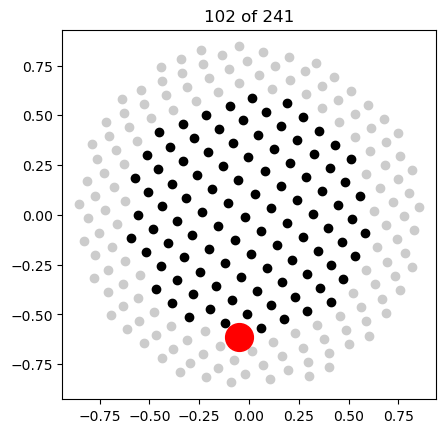

0.9096798156884934 -1.6495397043707234
<SkyCoord (AltAz: obstime=2023-03-08 02:13:44.318011, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (265.4883368, 52.12081415)>
<SkyCoord (ICRS): (ra, dec) in deg
    (85.4839717, -25.15489068)>
ra_h:dec_d 5.6989329182966:-25.1548745012617
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000196.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000150.fits']
---------------------------------


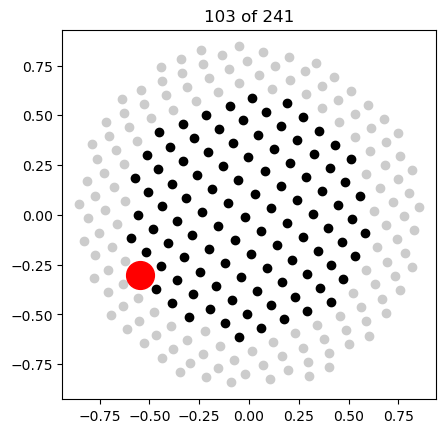

0.8987512435274725 -2.6363301278827795
<SkyCoord (AltAz: obstime=2023-03-08 02:14:06.711434, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (208.94941027, 51.49465309)>
<SkyCoord (ICRS): (ra, dec) in deg
    (92.63067196, -58.84990678)>
ra_h:dec_d 6.17537014239774:-58.8499072536341
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000197.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000151.fits']
---------------------------------


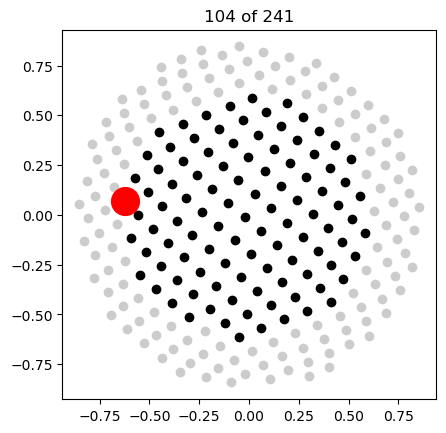

0.8964243345403567 3.029468582288915
<SkyCoord (AltAz: obstime=2023-03-08 02:14:25.949928, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (173.57576393, 51.36133102)>
<SkyCoord (ICRS): (ra, dec) in deg
    (138.69310208, -67.03316862)>
ra_h:dec_d 9.24626746747999:-67.0331654613986
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000198.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000152.fits']
---------------------------------


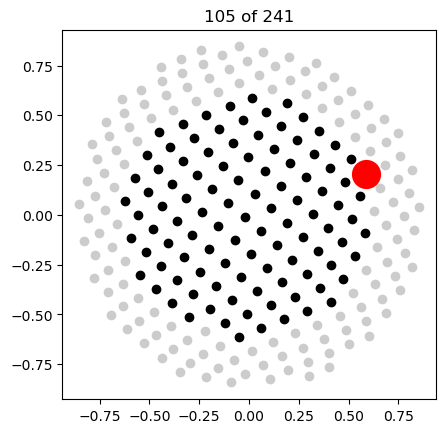

0.8958513539297643 0.33851835644186967
<SkyCoord (AltAz: obstime=2023-03-08 02:14:43.945612, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (19.39567311, 51.32850165)>
<SkyCoord (ICRS): (ra, dec) in deg
    (140.29607982, 7.96932701)>
ra_h:dec_d 9.35306719631734:7.9692204151215
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000199.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000153.fits']
---------------------------------


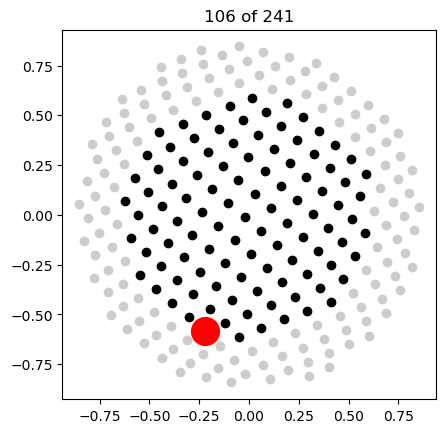

0.8946856977875737 -1.9338063705251984
<SkyCoord (AltAz: obstime=2023-03-08 02:15:04.576928, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (249.20105657, 51.26171447)>
<SkyCoord (ICRS): (ra, dec) in deg
    (82.87415596, -34.93999488)>
ra_h:dec_d 5.52494617704769:-34.9401493898266
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000200.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000154.fits']
---------------------------------


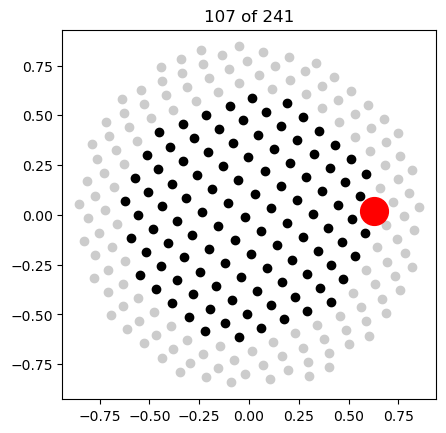

0.8922872036162722 0.03489659269600972
<SkyCoord (AltAz: obstime=2023-03-08 02:15:23.176620, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (1.99942748, 51.12429088)>
<SkyCoord (ICRS): (ra, dec) in deg
    (129.63623954, 9.93491132)>
ra_h:dec_d 8.64242228394537:9.93489052103177
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000201.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000155.fits']
---------------------------------


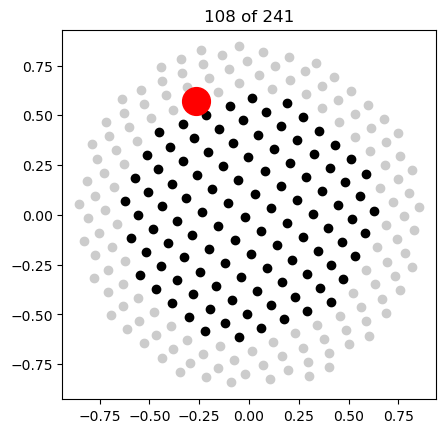

0.8864400884144004 2.008896464894618
<SkyCoord (AltAz: obstime=2023-03-08 02:15:41.551544, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (115.10128892, 50.78927586)>
<SkyCoord (ICRS): (ra, dec) in deg
    (174.73577824, -37.47772987)>
ra_h:dec_d 11.6490589403116:-37.477857473915
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000202.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000156.fits']
---------------------------------


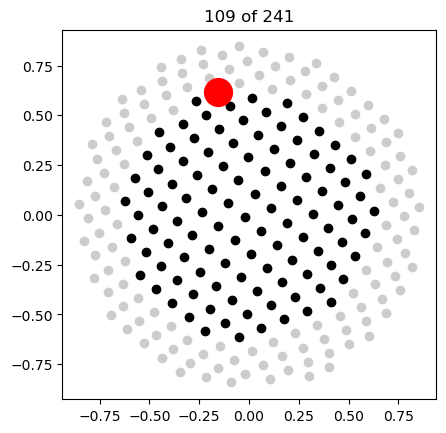

0.8818595981438198 1.8187980216903996
<SkyCoord (AltAz: obstime=2023-03-08 02:16:02.851916, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (104.20945043, 50.5268331)>
<SkyCoord (ICRS): (ra, dec) in deg
    (174.34499017, -30.58530707)>
ra_h:dec_d 11.6229958658074:-30.5853142968289
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000203.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000157.fits']
---------------------------------


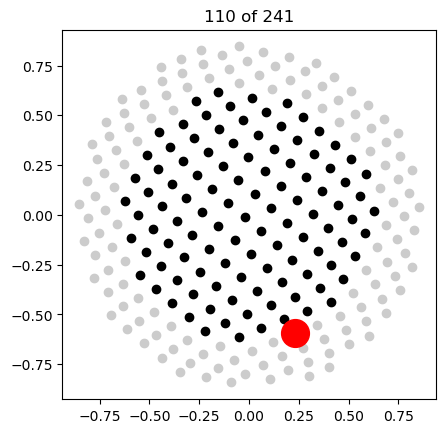

0.878988740636897 -1.2036334331778566
<SkyCoord (AltAz: obstime=2023-03-08 02:16:18.170815, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (291.0368842, 50.36234508)>
<SkyCoord (ICRS): (ra, dec) in deg
    (91.439572, -9.96418198)>
ra_h:dec_d 6.095971617585:-9.96419040564949
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000204.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000158.fits']
---------------------------------


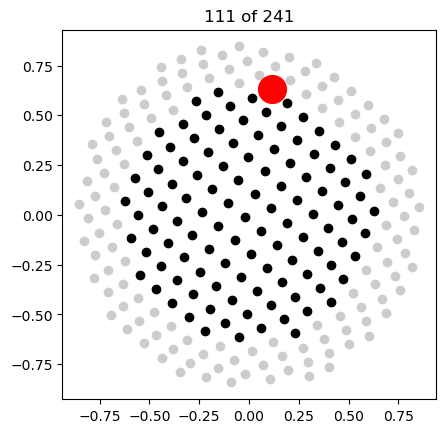

0.8716925952345458 1.389207630747814
<SkyCoord (AltAz: obstime=2023-03-08 02:16:41.147168, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (79.59573411, 49.94430674)>
<SkyCoord (ICRS): (ra, dec) in deg
    (169.80327419, -15.5055855)>
ra_h:dec_d 11.3202213522804:-15.5055909434748
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000205.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000159.fits']
---------------------------------


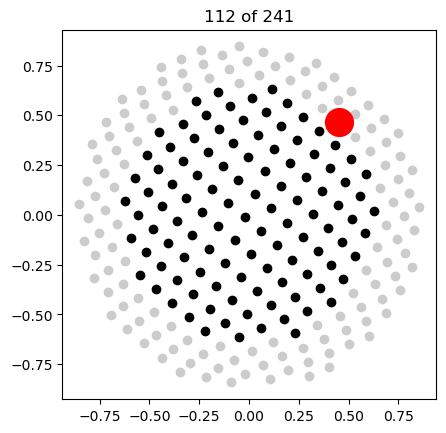

0.8682723136135818 0.8011295132917506
<SkyCoord (AltAz: obstime=2023-03-08 02:17:04.558686, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (45.90133995, 49.74833904)>
<SkyCoord (ICRS): (ra, dec) in deg
    (156.45678473, 1.44871761)>
ra_h:dec_d 10.4304513684517:1.44867187131981
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000206.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000160.fits']
---------------------------------


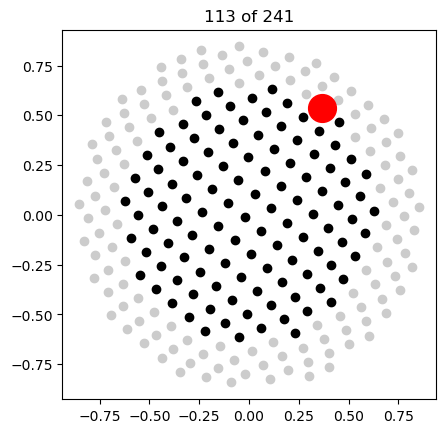

0.8646621991597119 0.9690906507488891
<SkyCoord (AltAz: obstime=2023-03-08 02:17:21.457644, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (55.52480425, 49.54149472)>
<SkyCoord (ICRS): (ra, dec) in deg
    (161.25601209, -2.60968385)>
ra_h:dec_d 10.750403628126:-2.60975115441429
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000207.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000161.fits']
---------------------------------


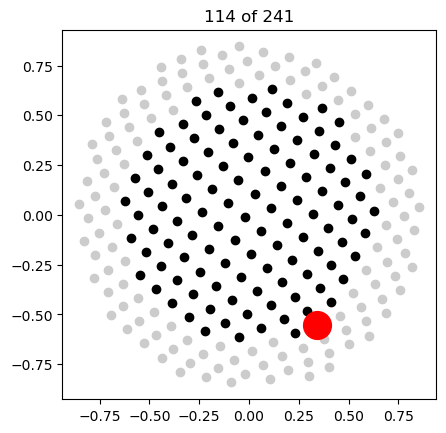

0.8643245942763076 -1.0155040062567253
<SkyCoord (AltAz: obstime=2023-03-08 02:17:37.220426, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (301.81590636, 49.52215138)>
<SkyCoord (ICRS): (ra, dec) in deg
    (95.3816948, -3.97262763)>
ra_h:dec_d 6.35878268331055:-3.97268845702046
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000208.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000162.fits']
---------------------------------


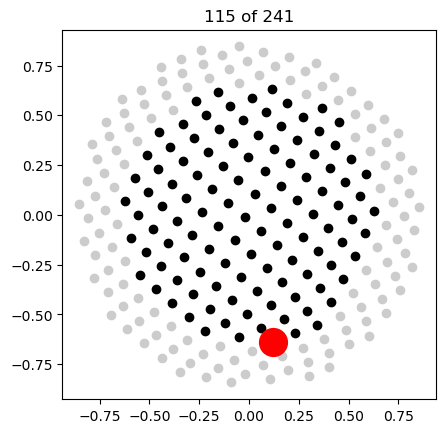

0.8629751558432411 -1.386820298037516
<SkyCoord (AltAz: obstime=2023-03-08 02:17:59.024398, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (280.54104998, 49.44483425)>
<SkyCoord (ICRS): (ra, dec) in deg
    (87.55673101, -15.33270864)>
ra_h:dec_d 5.83710834153736:-15.3327153920844
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000209.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000163.fits']
---------------------------------


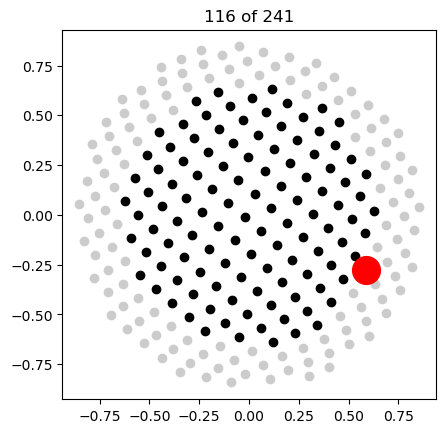

0.8625786829749289 -0.4422941958891249
<SkyCoord (AltAz: obstime=2023-03-08 02:18:14.647317, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (334.65840927, 49.42211803)>
<SkyCoord (ICRS): (ra, dec) in deg
    (112.73469673, 8.4387222)>
ra_h:dec_d 7.51564798313809:8.4387005371163
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000210.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000164.fits']
---------------------------------


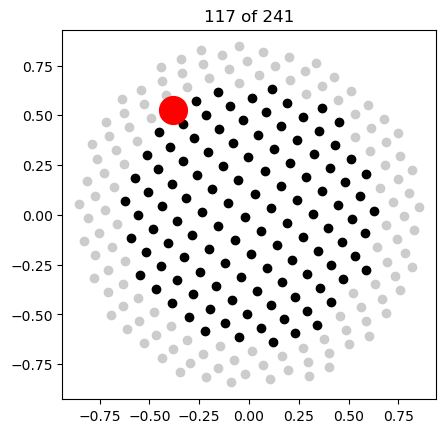

0.8601657354732124 2.196647761365219
<SkyCoord (AltAz: obstime=2023-03-08 02:18:32.227845, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (125.8586458, 49.28386632)>
<SkyCoord (ICRS): (ra, dec) in deg
    (177.07950938, -44.43468996)>
ra_h:dec_d 11.8053141327752:-44.4347877456388
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000211.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000165.fits']
---------------------------------


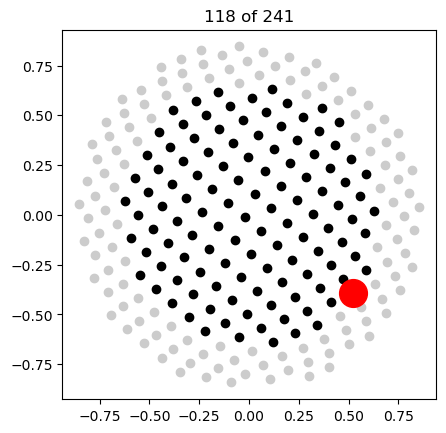

0.8555202518800958 -0.642781444677114
<SkyCoord (AltAz: obstime=2023-03-08 02:18:55.572486, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (323.17133607, 49.01769972)>
<SkyCoord (ICRS): (ra, dec) in deg
    (106.00205405, 5.37643247)>
ra_h:dec_d 7.06680785306279:5.37644372945889
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000212.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000166.fits']
---------------------------------


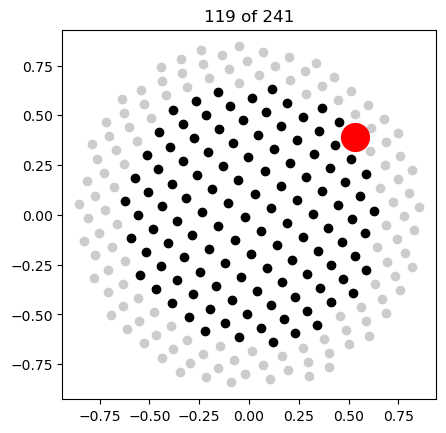

0.8495429458165024 0.6376870121014917
<SkyCoord (AltAz: obstime=2023-03-08 02:19:18.275926, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (36.53677444, 48.67522531)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.6272767, 5.84836674)>
ra_h:dec_d 10.175156233827:5.8483050044313
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000213.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000167.fits']
---------------------------------


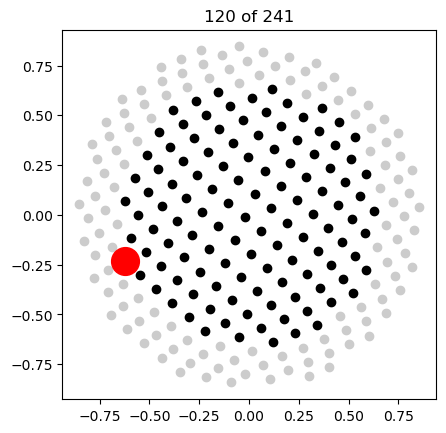

0.8480355574615899 -2.785734661306835
<SkyCoord (AltAz: obstime=2023-03-08 02:19:39.351265, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (200.38916106, 48.58885832)>
<SkyCoord (ICRS): (ra, dec) in deg
    (96.75546191, -64.92603559)>
ra_h:dec_d 6.45035417964834:-64.9259561956112
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000214.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000168.fits']
---------------------------------


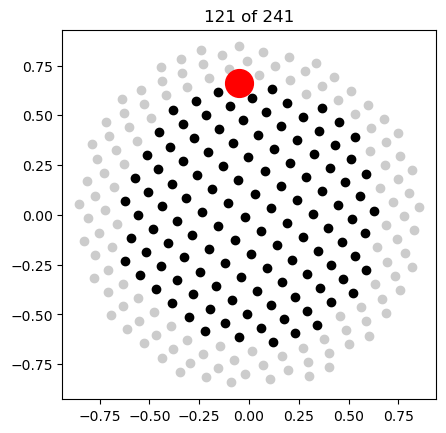

0.8474407377205907 1.6454002757807613
<SkyCoord (AltAz: obstime=2023-03-08 02:19:57.953573, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (94.27449141, 48.55477766)>
<SkyCoord (ICRS): (ra, dec) in deg
    (175.79127976, -23.86188991)>
ra_h:dec_d 11.7194179036128:-23.8619048596215
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000215.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000169.fits']
---------------------------------


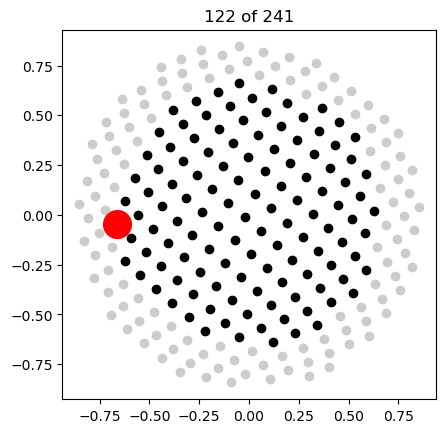

0.8472677641052527 -3.073812497606561
<SkyCoord (AltAz: obstime=2023-03-08 02:20:18.947739, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (183.88351687, 48.544867)>
<SkyCoord (ICRS): (ra, dec) in deg
    (122.29392644, -70.1612396)>
ra_h:dec_d 8.15293026422651:-70.1613063698937
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000216.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000170.fits']
---------------------------------


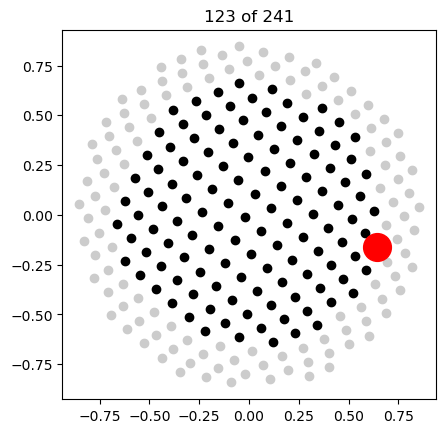

0.845448439028942 -0.24935511817673664
<SkyCoord (AltAz: obstime=2023-03-08 02:20:37.261929, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (345.71300413, 48.44062735)>
<SkyCoord (ICRS): (ra, dec) in deg
    (120.05267684, 11.56880421)>
ra_h:dec_d 8.00351291887064:11.5686818904436
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000217.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000171.fits']
---------------------------------


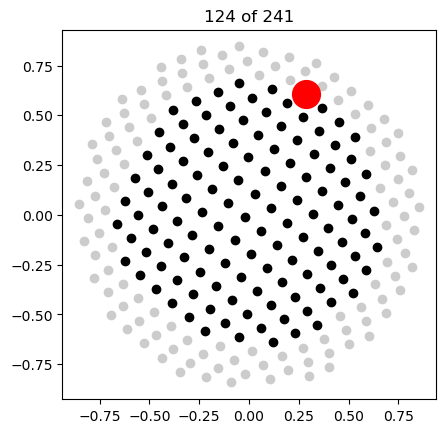

0.8369174418355266 1.1303668129468
<SkyCoord (AltAz: obstime=2023-03-08 02:20:59.079247, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (64.76524768, 47.95183722)>
<SkyCoord (ICRS): (ra, dec) in deg
    (167.34359077, -6.20716889)>
ra_h:dec_d 11.1562427553253:-6.2072328420917
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000218.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000172.fits']
---------------------------------


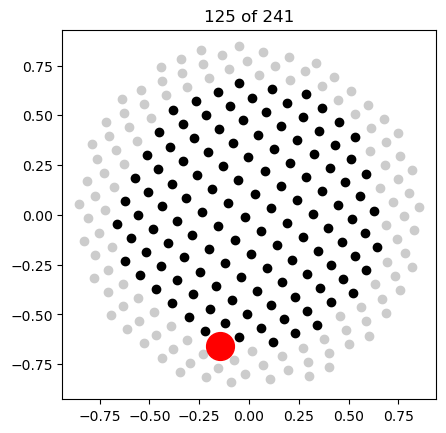

0.8339172167308413 -1.790058422989566
<SkyCoord (AltAz: obstime=2023-03-08 02:21:20.632855, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (257.43720728, 47.77993698)>
<SkyCoord (ICRS): (ra, dec) in deg
    (81.27791512, -29.15408861)>
ra_h:dec_d 5.41852290610881:-29.1543524710715
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000219.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000173.fits']
---------------------------------


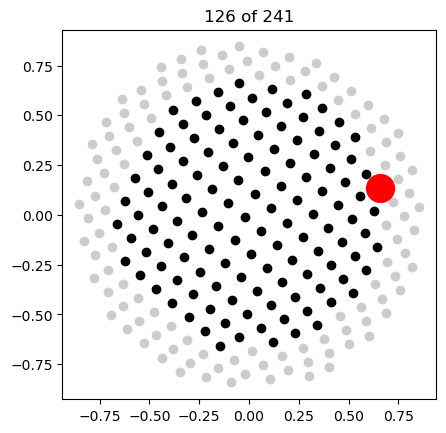

0.8310699351291414 0.20405896992293523
<SkyCoord (AltAz: obstime=2023-03-08 02:21:42.548762, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (11.69171775, 47.61679976)>
<SkyCoord (ICRS): (ra, dec) in deg
    (137.99318941, 12.75612681)>
ra_h:dec_d 9.19954839508581:12.7561010970433
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000220.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000174.fits']
---------------------------------


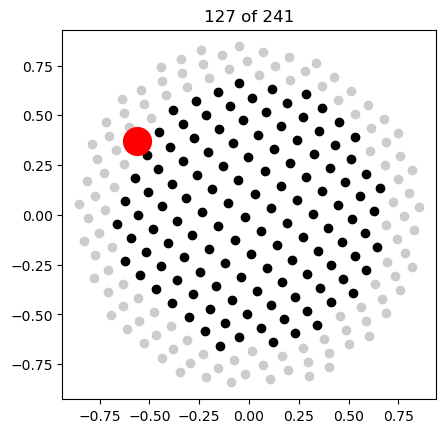

0.8308787222971978 2.5603780915281376
<SkyCoord (AltAz: obstime=2023-03-08 02:22:02.053789, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (146.6988586, 47.60584407)>
<SkyCoord (ICRS): (ra, dec) in deg
    (174.86946602, -58.18504205)>
ra_h:dec_d 11.6579660958353:-58.1851125320018
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000221.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000175.fits']
---------------------------------


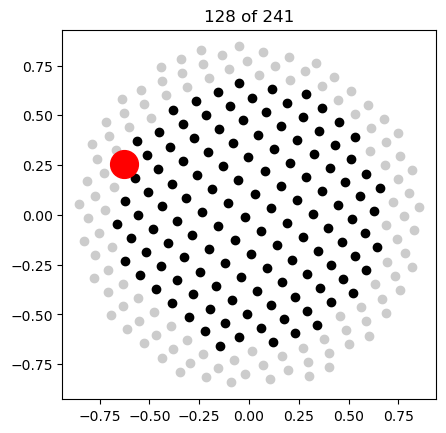

0.8296096164145355 2.75353753742235
<SkyCoord (AltAz: obstime=2023-03-08 02:22:24.225352, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (157.76607963, 47.53312966)>
<SkyCoord (ICRS): (ra, dec) in deg
    (166.94480662, -64.59787853)>
ra_h:dec_d 11.129659034972:-64.5980193505608
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000222.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000176.fits']
---------------------------------


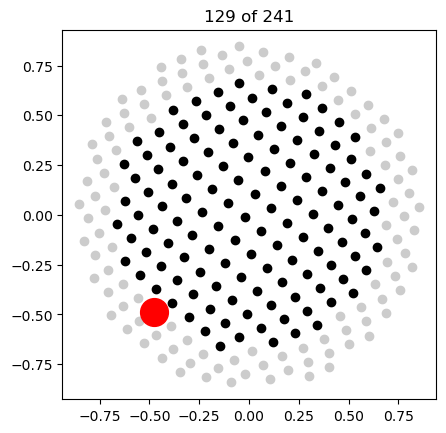

0.8215692608761687 -2.344971933411083
<SkyCoord (AltAz: obstime=2023-03-08 02:22:39.451448, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (225.64300514, 47.07245123)>
<SkyCoord (ICRS): (ra, dec) in deg
    (80.42179716, -50.50332594)>
ra_h:dec_d 5.36144973767299:-50.5032097235473
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000223.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000177.fits']
---------------------------------


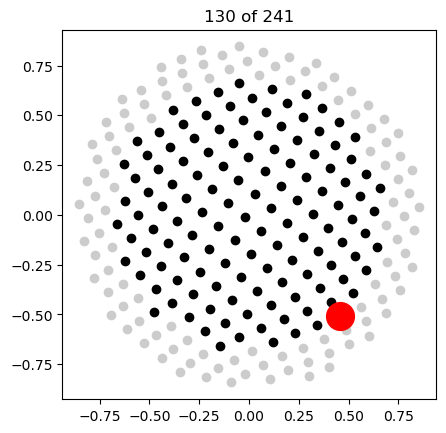

0.820466572728838 -0.8401393021731196
<SkyCoord (AltAz: obstime=2023-03-08 02:23:00.374625, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (311.86356378, 47.00927185)>
<SkyCoord (ICRS): (ra, dec) in deg
    (99.73643137, 2.50544672)>
ra_h:dec_d 6.6490912556553:2.50547178531611
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000224.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000178.fits']
---------------------------------


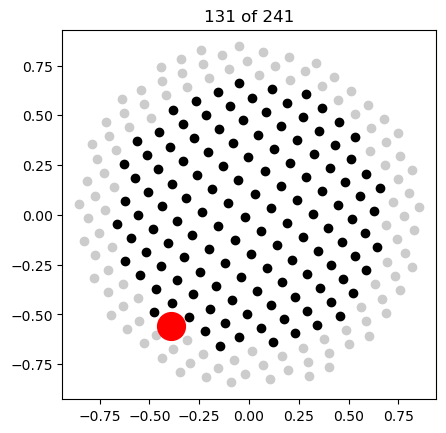

0.8193953870190689 -2.1850554472802006
<SkyCoord (AltAz: obstime=2023-03-08 02:23:19.663616, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (234.80554487, 46.94789743)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.28352549, -44.32046105)>
ra_h:dec_d 5.28556266965646:-44.320387680887
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000225.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000179.fits']
---------------------------------


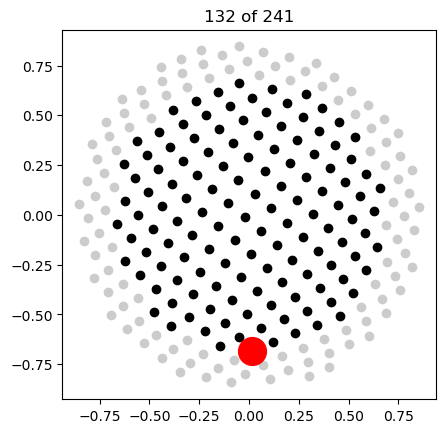

0.8186818678004922 -1.5477620697363197
<SkyCoord (AltAz: obstime=2023-03-08 02:23:38.249722, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (271.31976571, 46.90701579)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.91634981, -19.90700842)>
ra_h:dec_d 5.59441832910975:-19.907060762121
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000226.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000180.fits']
---------------------------------


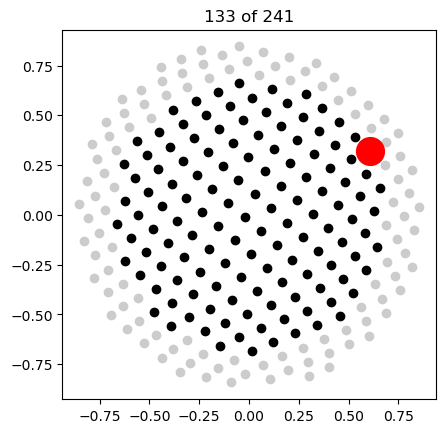

0.8116695715599563 0.4871771218543666
<SkyCoord (AltAz: obstime=2023-03-08 02:23:55.211881, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (27.91319296, 46.50524081)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.62794353, 10.49293972)>
ra_h:dec_d 9.97520351199155:10.4929525619514
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000227.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000181.fits']
---------------------------------


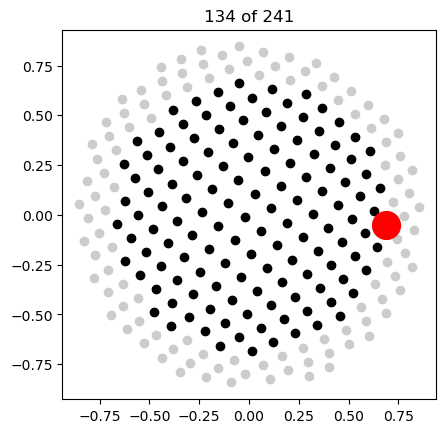

0.8086642852905273 -0.07103997032874011
<SkyCoord (AltAz: obstime=2023-03-08 02:24:16.447178, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (355.92970952, 46.33305059)>
<SkyCoord (ICRS): (ra, dec) in deg
    (127.6788469, 14.65163191)>
ra_h:dec_d 8.51192577727732:14.6516153981561
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000228.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000182.fits']
---------------------------------


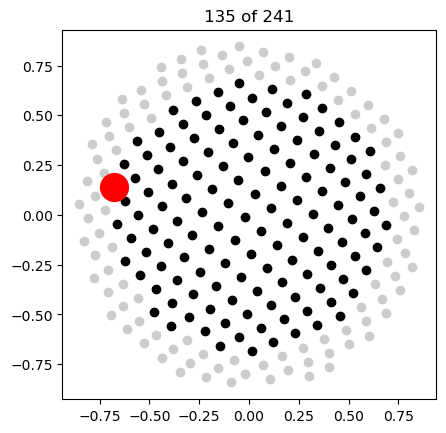

0.806289708313007 2.936789912606274
<SkyCoord (AltAz: obstime=2023-03-08 02:24:34.284519, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (168.26566731, 46.19699735)>
<SkyCoord (ICRS): (ra, dec) in deg
    (155.77122938, -70.38560541)>
ra_h:dec_d 10.384744372117:-70.3857183476017
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000229.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000183.fits']
---------------------------------


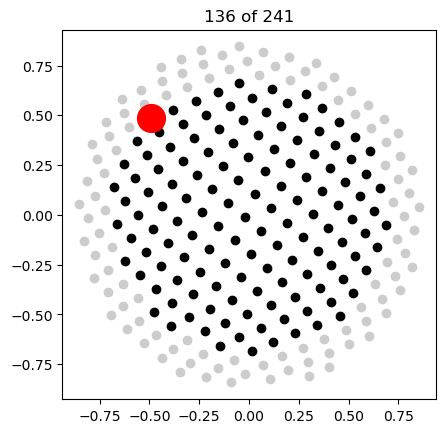

0.8059307495424803 2.365847134888498
<SkyCoord (AltAz: obstime=2023-03-08 02:24:57.185066, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (135.5530558, 46.17643053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (181.86696264, -51.33004714)>
ra_h:dec_d 12.1244629555899:-51.3300440158613
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000230.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000184.fits']
---------------------------------


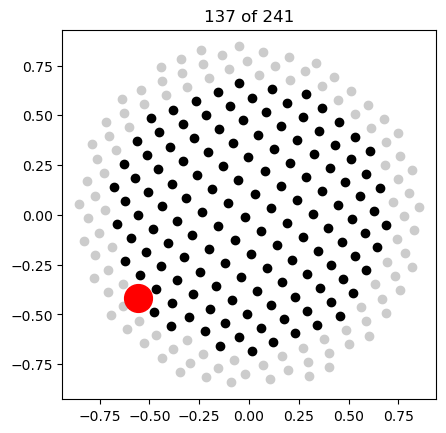

0.8020635064785394 -2.500025812715695
<SkyCoord (AltAz: obstime=2023-03-08 02:25:15.563716, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.75907226, 45.95485382)>
<SkyCoord (ICRS): (ra, dec) in deg
    (81.80792005, -56.69804926)>
ra_h:dec_d 5.45386874991084:-56.698040021779
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000231.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000185.fits']
---------------------------------


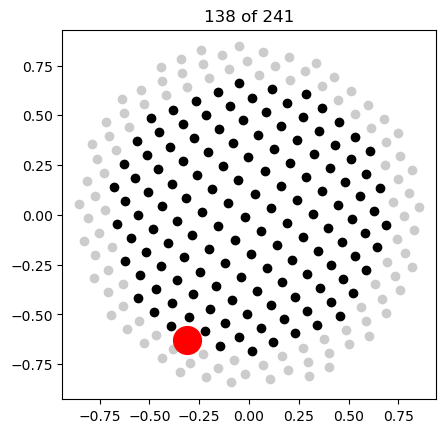

0.793404347802674 -2.0299343209523077
<SkyCoord (AltAz: obstime=2023-03-08 02:25:37.227896, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (243.69333072, 45.45872058)>
<SkyCoord (ICRS): (ra, dec) in deg
    (77.97912207, -38.15377613)>
ra_h:dec_d 5.19860949323856:-38.1538064537842
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000232.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000186.fits']
---------------------------------


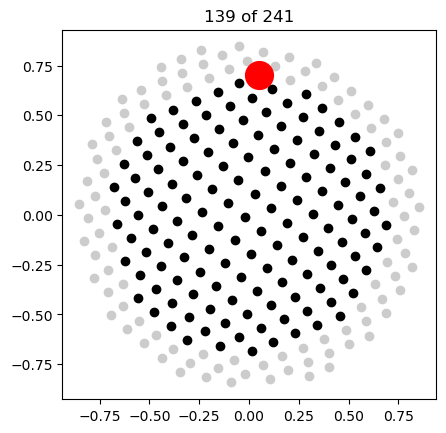

0.78765056253104 1.5023057784251033
<SkyCoord (AltAz: obstime=2023-03-08 02:25:53.574907, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (86.07578064, 45.12905296)>
<SkyCoord (ICRS): (ra, dec) in deg
    (178.59141314, -17.41152193)>
ra_h:dec_d 11.90612420694:-17.4114015197854
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000233.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000187.fits']
---------------------------------


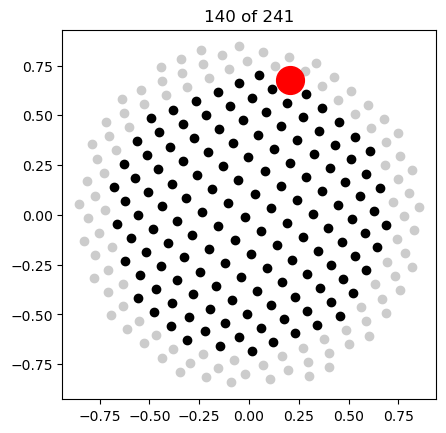

0.7847331511848127 1.2745135833162402
<SkyCoord (AltAz: obstime=2023-03-08 02:26:16.548362, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (73.02424926, 44.96189761)>
<SkyCoord (ICRS): (ra, dec) in deg
    (174.40981975, -9.19017088)>
ra_h:dec_d 11.6273195430344:-9.19027194140849
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000234.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000188.fits']
---------------------------------


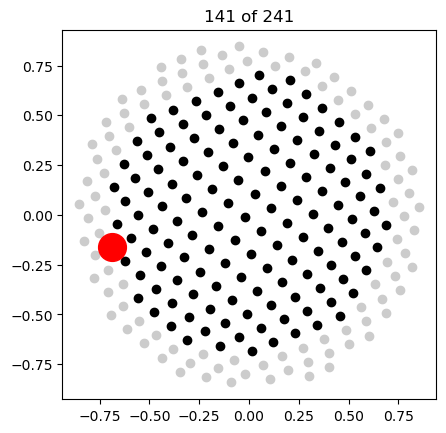

0.784290745497101 -2.9142638430773267
<SkyCoord (AltAz: obstime=2023-03-08 02:26:31.968878, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (193.0249814, 44.93654963)>
<SkyCoord (ICRS): (ra, dec) in deg
    (102.15416761, -70.99376843)>
ra_h:dec_d 6.81028676810427:-70.9938231787006
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000235.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000189.fits']
---------------------------------


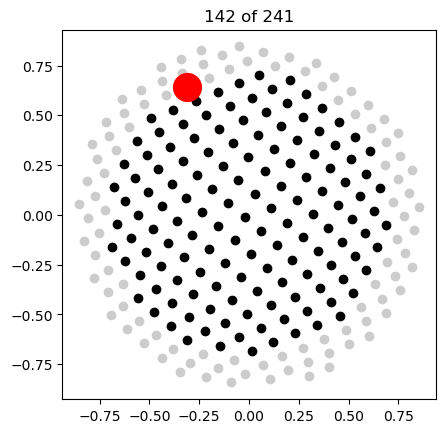

0.7758128563953303 2.0188842452356495
<SkyCoord (AltAz: obstime=2023-03-08 02:26:51.059097, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (115.67354658, 44.45080236)>
<SkyCoord (ICRS): (ra, dec) in deg
    (185.53208852, -37.46364088)>
ra_h:dec_d 12.3688072226785:-37.4636280235609
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000236.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000190.fits']
---------------------------------


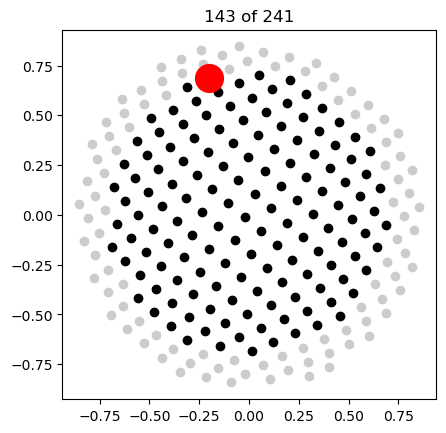

0.772281669113232 1.8570406089659288
<SkyCoord (AltAz: obstime=2023-03-08 02:27:12.398103, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (106.40058928, 44.24848024)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.63694047, -30.88287826)>
ra_h:dec_d 12.3091304914015:-30.8829176895965
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000237.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000191.fits']
---------------------------------


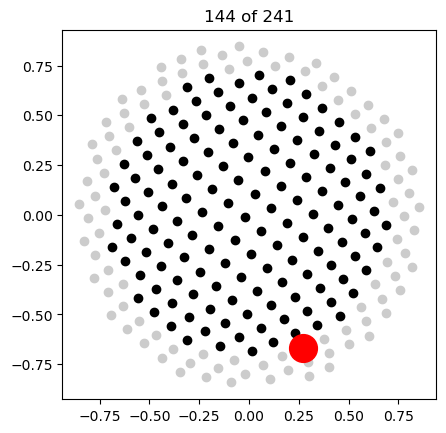

0.7680689046107447 -1.1847460968952894
<SkyCoord (AltAz: obstime=2023-03-08 02:27:27.665925, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (292.11904885, 44.00710661)>
<SkyCoord (ICRS): (ra, dec) in deg
    (89.38097088, -5.73945712)>
ra_h:dec_d 5.95873182189724:-5.73945012126755
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000238.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000192.fits']
---------------------------------


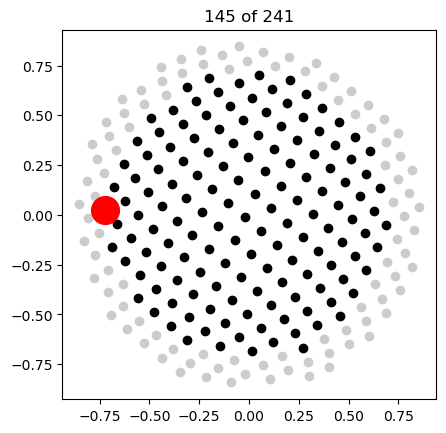

0.7654223498676096 3.105432797310311
<SkyCoord (AltAz: obstime=2023-03-08 02:27:52.508666, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (177.92819285, 43.85547019)>
<SkyCoord (ICRS): (ra, dec) in deg
    (137.6269806, -74.9599236)>
ra_h:dec_d 9.17513230551927:-74.9599955191214
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000239.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000193.fits']
---------------------------------


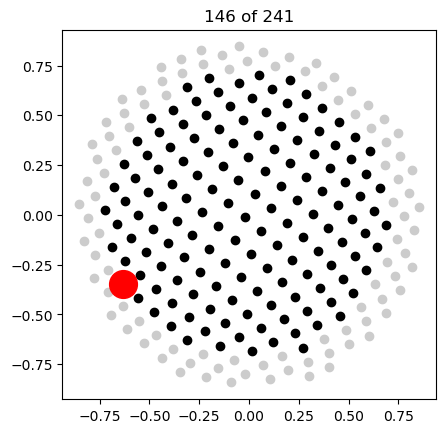

0.7640938593877662 -2.643168056638046
<SkyCoord (AltAz: obstime=2023-03-08 02:28:16.070350, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (208.55762581, 43.77935329)>
<SkyCoord (ICRS): (ra, dec) in deg
    (82.63164988, -62.89910057)>
ra_h:dec_d 5.50878278800016:-62.8991299763075
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000240.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000194.fits']
---------------------------------


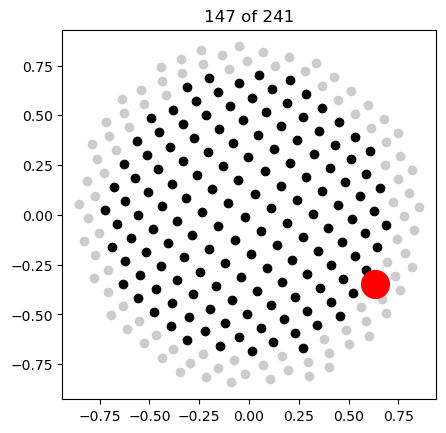

0.7629941848882963 -0.504432076728682
<SkyCoord (AltAz: obstime=2023-03-08 02:28:35.277801, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (331.09817095, 43.71634659)>
<SkyCoord (ICRS): (ra, dec) in deg
    (110.68902299, 12.65487559)>
ra_h:dec_d 7.37926865664658:12.6548628840551
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000241.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000195.fits']
---------------------------------


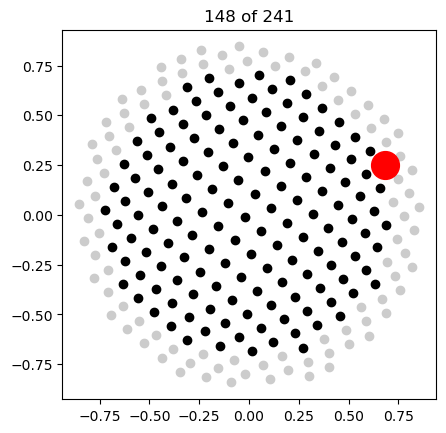

0.7585059714348648 0.3535310359632155
<SkyCoord (AltAz: obstime=2023-03-08 02:28:55.977265, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (20.25583629, 43.4591909)>
<SkyCoord (ICRS): (ra, dec) in deg
    (146.84980381, 15.30080203)>
ra_h:dec_d 9.78998735469642:15.3007889355363
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000242.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000196.fits']
---------------------------------


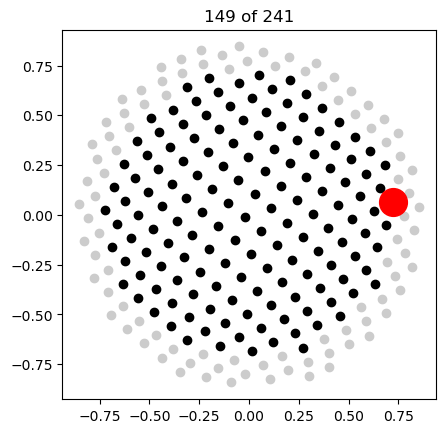

0.7567930269354234 0.09048058492882798
<SkyCoord (AltAz: obstime=2023-03-08 02:29:16.247717, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (5.18415564, 43.36104641)>
<SkyCoord (ICRS): (ra, dec) in deg
    (135.78096272, 17.5711868)>
ra_h:dec_d 9.05206744210551:17.5712007771664
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000243.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000197.fits']
---------------------------------


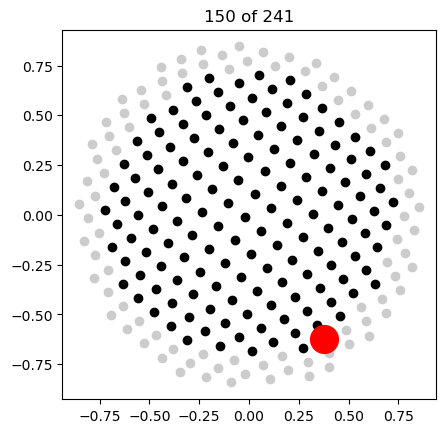

0.7542550328796063 -1.0240049814416579
<SkyCoord (AltAz: obstime=2023-03-08 02:29:32.750582, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (301.32883636, 43.21563006)>
<SkyCoord (ICRS): (ra, dec) in deg
    (93.43181338, -0.02615574)>
ra_h:dec_d 6.22879075265576:-0.0262033572683721
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000244.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000198.fits']
---------------------------------


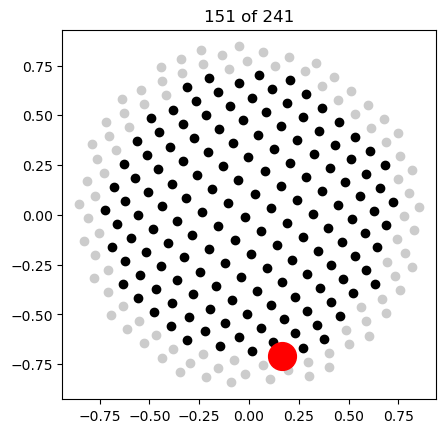

0.7535710224141974 -1.34120825822408
<SkyCoord (AltAz: obstime=2023-03-08 02:29:51.603336, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (283.15442736, 43.17643915)>
<SkyCoord (ICRS): (ra, dec) in deg
    (85.74890045, -10.76358024)>
ra_h:dec_d 5.71659049065586:-10.7635423597103
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000245.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000199.fits']
---------------------------------


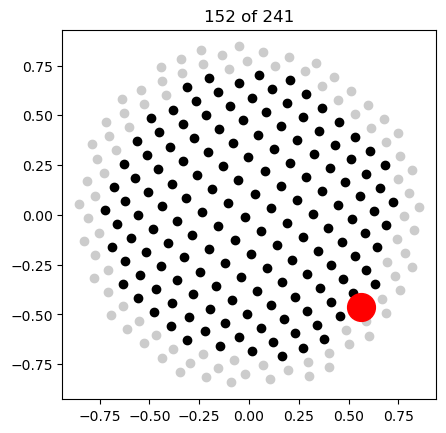

0.7519081782740121 -0.6884151166505362
<SkyCoord (AltAz: obstime=2023-03-08 02:30:07.277137, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (320.55671926, 43.0811652)>
<SkyCoord (ICRS): (ra, dec) in deg
    (104.00488159, 9.36137255)>
ra_h:dec_d 6.93365888236952:9.36138862951973
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000246.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000200.fits']
---------------------------------


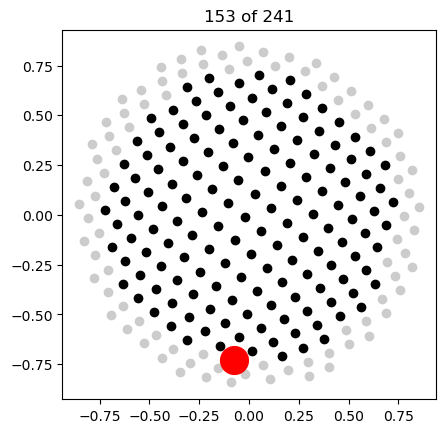

0.7512209714927389 -1.6762154676763292
<SkyCoord (AltAz: obstime=2023-03-08 02:30:24.359134, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (263.95992815, 43.04179115)>
<SkyCoord (ICRS): (ra, dec) in deg
    (79.80076558, -23.4855311)>
ra_h:dec_d 5.32005256242666:-23.4855385399329
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000247.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000201.fits']
---------------------------------


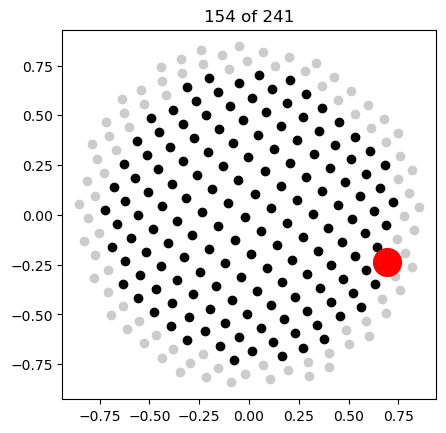

0.7511908212702341 -0.3267967247703787
<SkyCoord (AltAz: obstime=2023-03-08 02:30:41.957954, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (341.27592691, 43.04006367)>
<SkyCoord (ICRS): (ra, dec) in deg
    (118.0647861, 15.98996335)>
ra_h:dec_d 7.87098655158816:15.9899815664457
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000248.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000202.fits']
---------------------------------


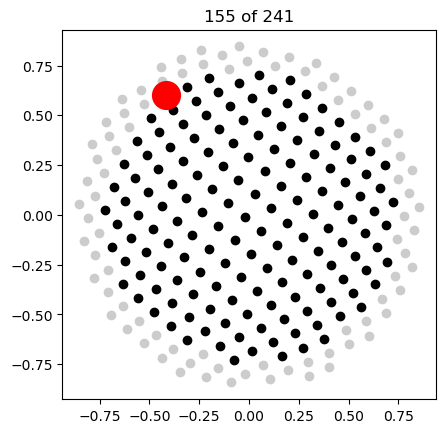

0.7511046407218754 2.1796655630430712
<SkyCoord (AltAz: obstime=2023-03-08 02:30:59.559747, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (124.88563751, 43.03512589)>
<SkyCoord (ICRS): (ra, dec) in deg
    (188.95155416, -44.02131403)>
ra_h:dec_d 12.5968112317093:-44.0212473314059
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000249.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000203.fits']
---------------------------------


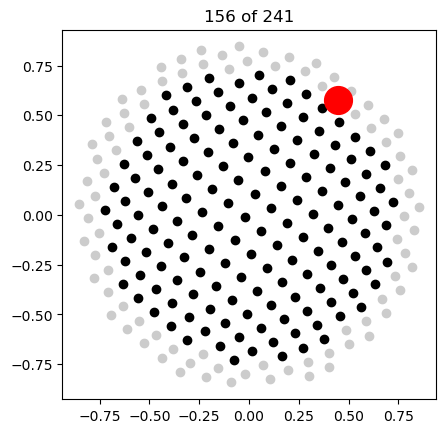

0.7485642938432887 0.9106333974552873
<SkyCoord (AltAz: obstime=2023-03-08 02:31:24.663588, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (52.17545036, 42.88957473)>
<SkyCoord (ICRS): (ra, dec) in deg
    (167.83652322, 3.73720845)>
ra_h:dec_d 11.1891014141634:3.7370596433997
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000250.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000204.fits']
---------------------------------


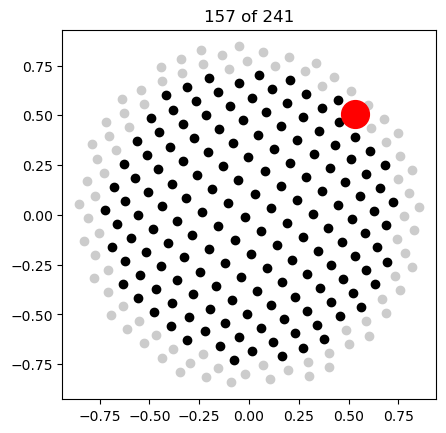

0.7440686061908892 0.761816804854569
<SkyCoord (AltAz: obstime=2023-03-08 02:31:51.164912, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (43.64888768, 42.6319908)>
<SkyCoord (ICRS): (ra, dec) in deg
    (163.34344836, 8.01034005)>
ra_h:dec_d 10.889564276538:8.01026265900058
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000251.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000205.fits']
---------------------------------


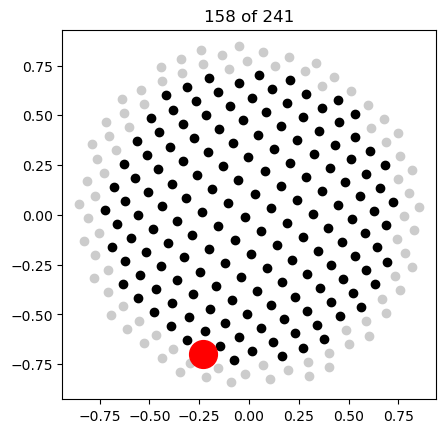

0.7426215763385791 -1.889121993320371
<SkyCoord (AltAz: obstime=2023-03-08 02:32:06.174593, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (251.7612828, 42.5490821)>
<SkyCoord (ICRS): (ra, dec) in deg
    (77.08252397, -31.99925811)>
ra_h:dec_d 5.13883457979881:-31.9993198416677
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000252.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000206.fits']
---------------------------------


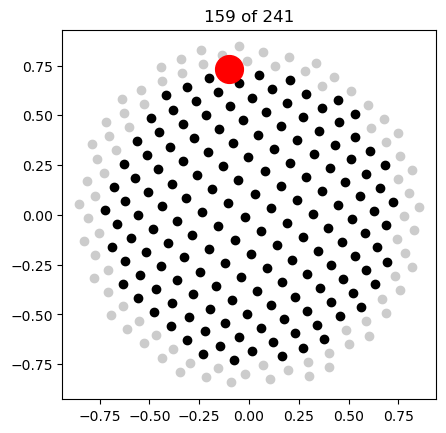

0.7408446529658023 1.7079451829076413
<SkyCoord (AltAz: obstime=2023-03-08 02:32:27.749627, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (97.85805062, 42.44727189)>
<SkyCoord (ICRS): (ra, dec) in deg
    (186.13073982, -24.42028929)>
ra_h:dec_d 12.4087224873223:-24.4202594243166
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000253.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000207.fits']
---------------------------------


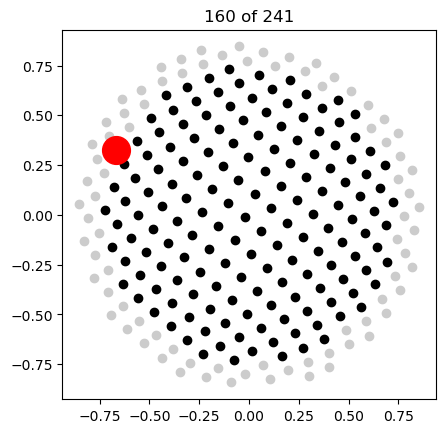

0.731912276437534 2.687390746979612
<SkyCoord (AltAz: obstime=2023-03-08 02:32:52.259321, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (153.9761477, 41.93548441)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.1586768, -65.19531388)>
ra_h:dec_d 12.2772547217142:-65.1954744176282
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000254.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000208.fits']
---------------------------------


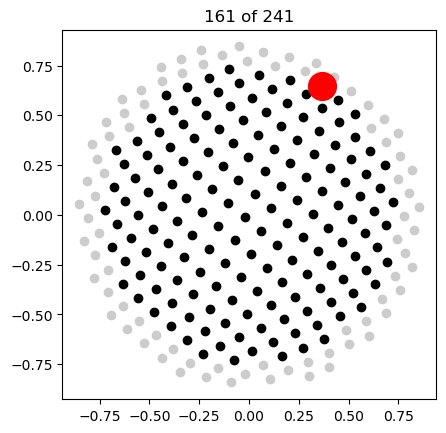

0.7300069854631611 1.058854085704558
<SkyCoord (AltAz: obstime=2023-03-08 02:33:19.156227, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (60.66787023, 41.82631928)>
<SkyCoord (ICRS): (ra, dec) in deg
    (173.38933679, -0.10472564)>
ra_h:dec_d 11.5592913543757:-0.104804031070159
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000255.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000209.fits']
---------------------------------


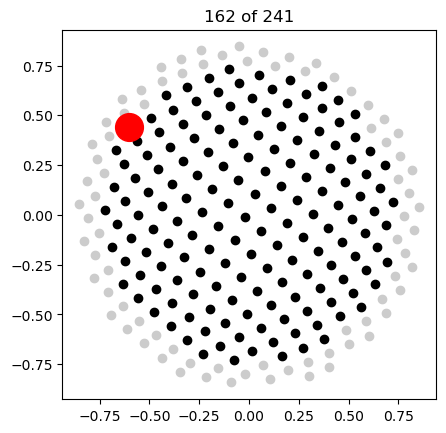

0.7289673064996842 2.508829889482794
<SkyCoord (AltAz: obstime=2023-03-08 02:33:46.448891, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (143.74536418, 41.76675007)>
<SkyCoord (ICRS): (ra, dec) in deg
    (189.54474104, -57.97708639)>
ra_h:dec_d 12.6363213783236:-57.9771640025835
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000256.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000210.fits']
---------------------------------


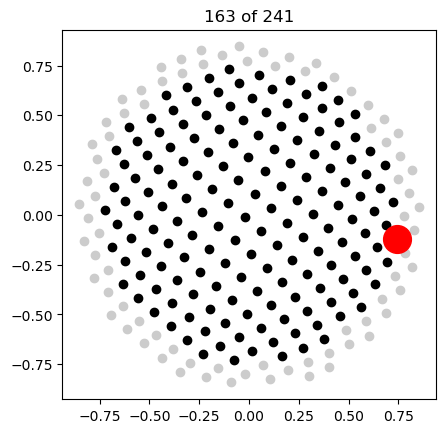

0.7208622860208128 -0.16031130195388135
<SkyCoord (AltAz: obstime=2023-03-08 02:34:14.048782, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (350.81483899, 41.3023666)>
<SkyCoord (ICRS): (ra, dec) in deg
    (125.774116, 19.25685017)>
ra_h:dec_d 8.38493923938734:19.2568058881374
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000257.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000211.fits']
---------------------------------


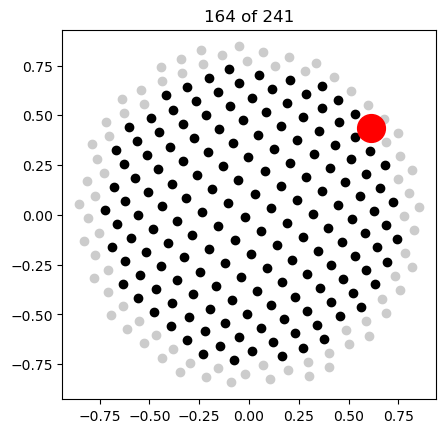

0.7193359974289302 0.6197282169859514
<SkyCoord (AltAz: obstime=2023-03-08 02:34:39.171107, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (35.50781128, 41.2149167)>
<SkyCoord (ICRS): (ra, dec) in deg
    (159.78121901, 12.60118586)>
ra_h:dec_d 10.652085277473:12.6011209588092
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000258.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000212.fits']
---------------------------------


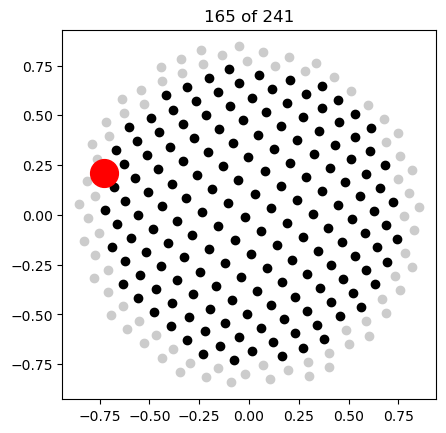

0.7139094582229182 2.857725971632081
<SkyCoord (AltAz: obstime=2023-03-08 02:34:59.574286, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (163.73563718, 40.90399891)>
<SkyCoord (ICRS): (ra, dec) in deg
    (177.08957517, -72.05819222)>
ra_h:dec_d 11.8059854954527:-72.0583647407926
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000259.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000213.fits']
---------------------------------


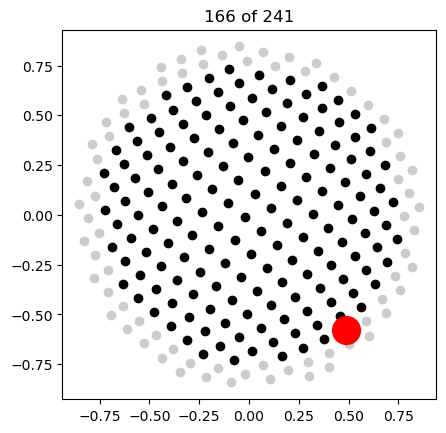

0.7135506610204787 -0.8717711526069408
<SkyCoord (AltAz: obstime=2023-03-08 02:35:27.160106, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (310.05119225, 40.88344135)>
<SkyCoord (ICRS): (ra, dec) in deg
    (97.79763881, 6.22480253)>
ra_h:dec_d 6.51983976445993:6.22474907551221
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000260.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000214.fits']
---------------------------------


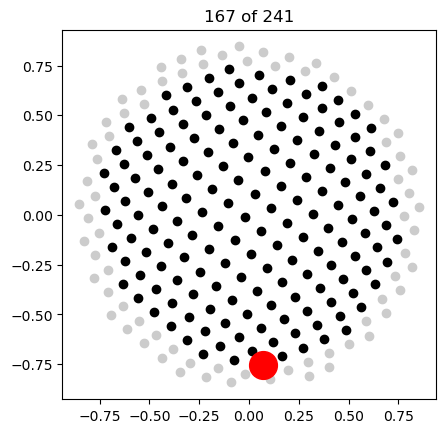

0.712085212922978 -1.4804017118087418
<SkyCoord (AltAz: obstime=2023-03-08 02:35:51.962413, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (275.17922993, 40.79947735)>
<SkyCoord (ICRS): (ra, dec) in deg
    (82.27956598, -14.91052383)>
ra_h:dec_d 5.48530213135658:-14.9104282835437
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000261.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000215.fits']
---------------------------------


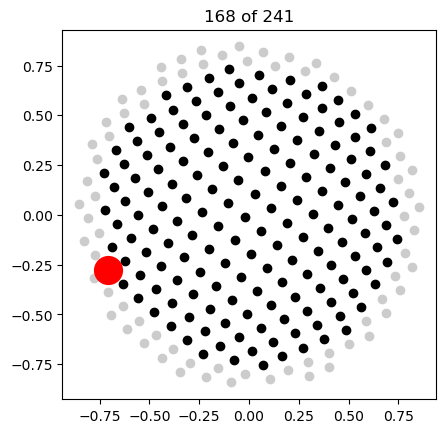

0.711342924068017 -2.7711317975378056
<SkyCoord (AltAz: obstime=2023-03-08 02:36:09.266855, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (201.22584353, 40.75694734)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.73663606, -69.09195258)>
ra_h:dec_d 5.58244727768456:-69.092002183065
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000262.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000216.fits']
---------------------------------


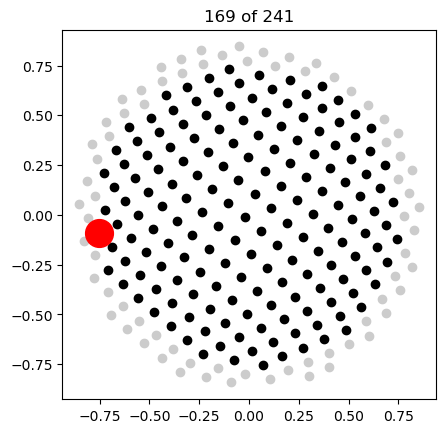

0.7112529839569238 -3.0243223560338484
<SkyCoord (AltAz: obstime=2023-03-08 02:36:30.158783, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (186.71909311, 40.75179415)>
<SkyCoord (ICRS): (ra, dec) in deg
    (110.91965157, -76.98502175)>
ra_h:dec_d 7.39468051313637:-76.9851034727714
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000263.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000217.fits']
---------------------------------


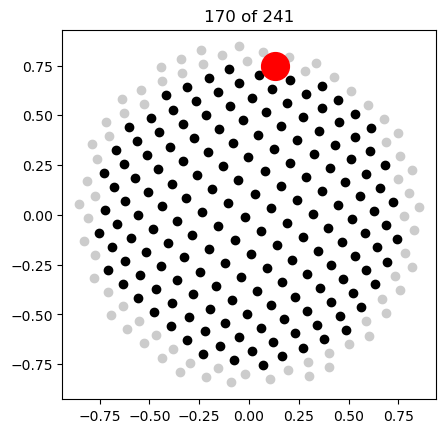

0.7083961453946037 1.3946370745479937
<SkyCoord (AltAz: obstime=2023-03-08 02:36:46.853236, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (79.90681832, 40.58810935)>
<SkyCoord (ICRS): (ra, dec) in deg
    (183.46399306, -11.35241289)>
ra_h:dec_d 12.2309303946825:-11.3523622546655
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000264.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000218.fits']
---------------------------------


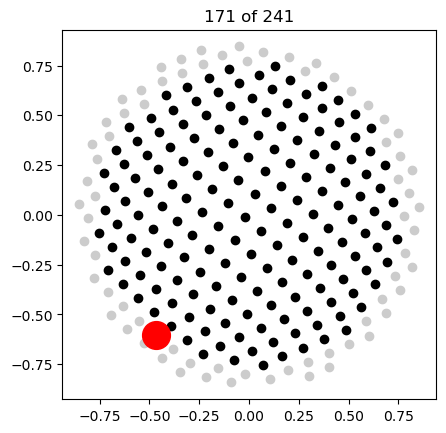

0.702992818059447 -2.2329848934864422
<SkyCoord (AltAz: obstime=2023-03-08 02:37:06.882159, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (232.05938989, 40.2785215)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.28528795, -46.39491426)>
ra_h:dec_d 4.8856954497641:-46.3949942477972
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000265.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000219.fits']
---------------------------------


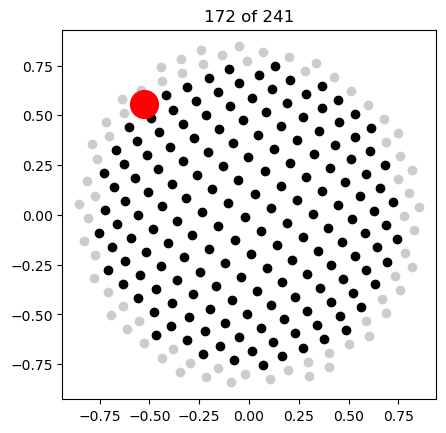

0.7005710701688704 2.327622254196468
<SkyCoord (AltAz: obstime=2023-03-08 02:37:29.772175, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (133.36293147, 40.13976557)>
<SkyCoord (ICRS): (ra, dec) in deg
    (194.78569277, -50.37795426)>
ra_h:dec_d 12.9857213106679:-50.3780111504142
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000266.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000220.fits']
---------------------------------


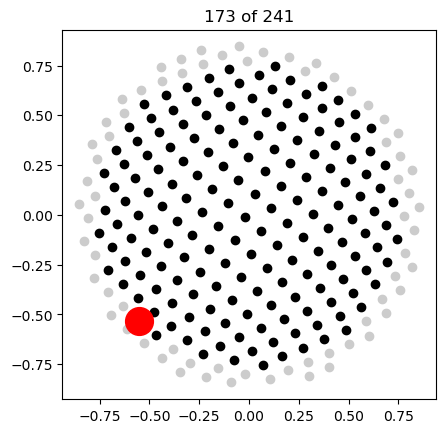

0.6978170388225379 -2.3763989819737663
<SkyCoord (AltAz: obstime=2023-03-08 02:37:56.955149, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (223.84236789, 39.9819712)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.18434866, -52.67838041)>
ra_h:dec_d 4.8789607733478:-52.6784329822423
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000267.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000221.fits']
---------------------------------


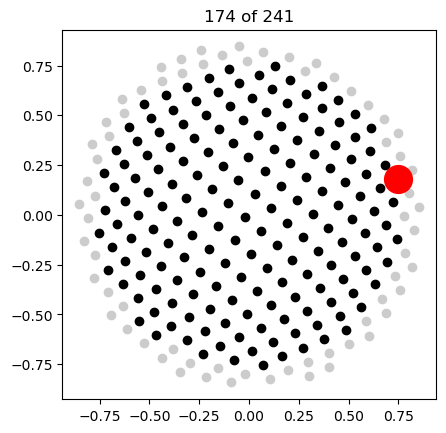

0.6937986197170892 0.2368478594893555
<SkyCoord (AltAz: obstime=2023-03-08 02:38:22.761980, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (13.57038274, 39.75173274)>
<SkyCoord (ICRS): (ra, dec) in deg
    (145.19063166, 20.20096047)>
ra_h:dec_d 9.67937908651381:20.2008541039069
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000268.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000222.fits']
---------------------------------


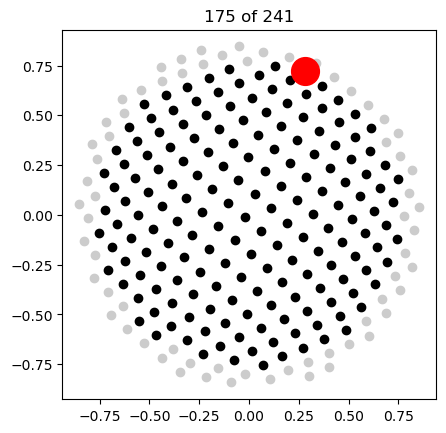

0.6862766336096165 1.1982445643664443
<SkyCoord (AltAz: obstime=2023-03-08 02:38:42.252888, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (68.65435636, 39.32075468)>
<SkyCoord (ICRS): (ra, dec) in deg
    (180.43520945, -3.36484373)>
ra_h:dec_d 12.0290208162219:-3.36495641780321
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000269.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000223.fits']
---------------------------------


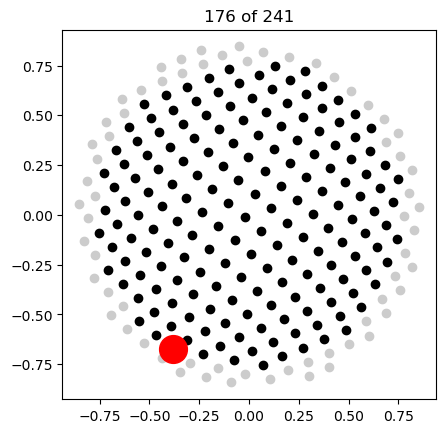

0.6851829654981583 -2.0891816052857988
<SkyCoord (AltAz: obstime=2023-03-08 02:39:02.166502, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (240.29871138, 39.25809212)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.06403906, -40.00232636)>
ra_h:dec_d 4.87093474843106:-40.0023964057981
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000270.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000224.fits']
---------------------------------


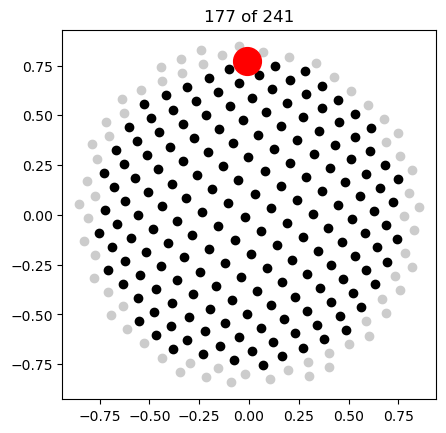

0.6843650169905103 1.5827381638290716
<SkyCoord (AltAz: obstime=2023-03-08 02:39:25.353939, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (90.68421686, 39.21122712)>
<SkyCoord (ICRS): (ra, dec) in deg
    (189.10625227, -18.20926886)>
ra_h:dec_d 12.6070877473649:-18.2092679523151
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000271.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000225.fits']
---------------------------------


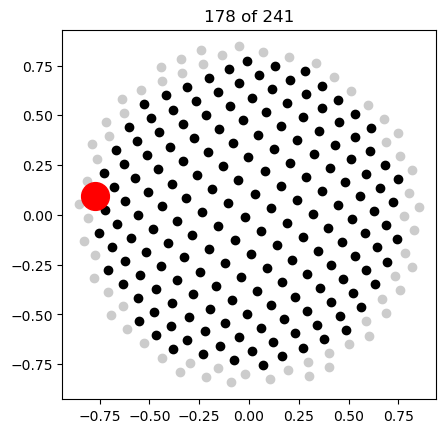

0.679260227933523 3.016625844464743
<SkyCoord (AltAz: obstime=2023-03-08 02:39:49.873378, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (172.83992926, 38.91874425)>
<SkyCoord (ICRS): (ra, dec) in deg
    (163.64473623, -78.32896664)>
ra_h:dec_d 10.9096510099581:-78.3289093916226
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000272.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000226.fits']
---------------------------------


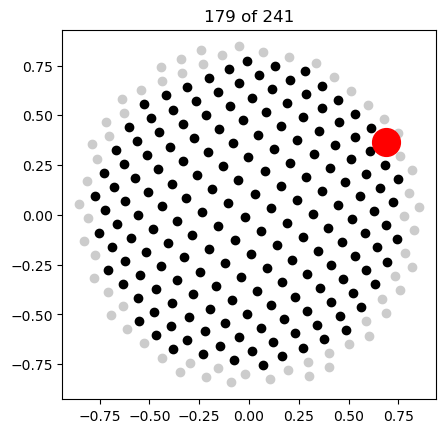

0.677744346822511 0.4891182837730629
<SkyCoord (AltAz: obstime=2023-03-08 02:40:07.598403, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (28.02441334, 38.83189066)>
<SkyCoord (ICRS): (ra, dec) in deg
    (157.1062931, 17.41994718)>
ra_h:dec_d 10.473752854874:17.4198462727744
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000273.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000227.fits']
---------------------------------


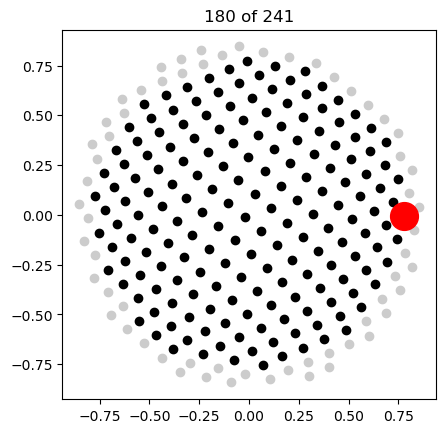

0.6761693026862389 -0.0066845710826208896
<SkyCoord (AltAz: obstime=2023-03-08 02:40:29.658069, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (359.61700229, 38.74164728)>
<SkyCoord (ICRS): (ra, dec) in deg
    (134.31289864, 22.34330288)>
ra_h:dec_d 8.95419567139947:22.3433558960837
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000274.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000228.fits']
---------------------------------


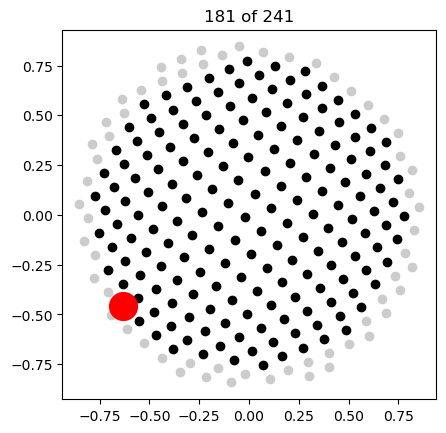

0.6727300475119607 -2.513063282193731
<SkyCoord (AltAz: obstime=2023-03-08 02:40:47.891369, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.01208028, 38.54459247)>
<SkyCoord (ICRS): (ra, dec) in deg
    (72.34261724, -58.84363161)>
ra_h:dec_d 4.82284237220908:-58.8435296575491
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000275.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000229.fits']
---------------------------------


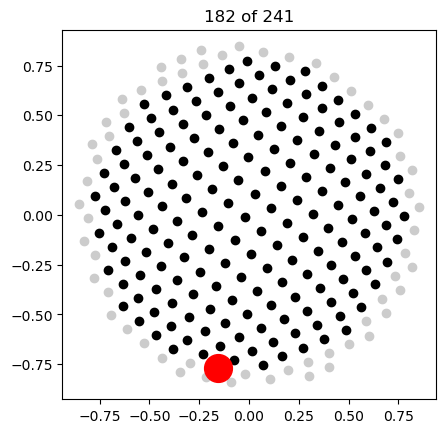

0.666383333350433 -1.7695060963594673
<SkyCoord (AltAz: obstime=2023-03-08 02:41:08.152930, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (258.61476886, 38.18095254)>
<SkyCoord (ICRS): (ra, dec) in deg
    (76.02861544, -25.84089675)>
ra_h:dec_d 5.06856816070987:-25.840903803321
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000276.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000230.fits']
---------------------------------


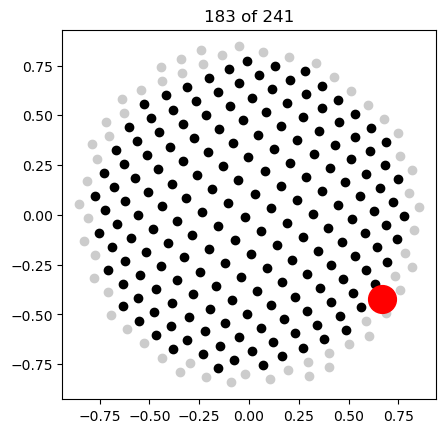

0.664149729893484 -0.562927799751065
<SkyCoord (AltAz: obstime=2023-03-08 02:41:25.814525, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (327.7466129, 38.05297649)>
<SkyCoord (ICRS): (ra, dec) in deg
    (108.88406538, 16.51338333)>
ra_h:dec_d 7.25893721611069:16.5133742848197
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000277.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000231.fits']
---------------------------------


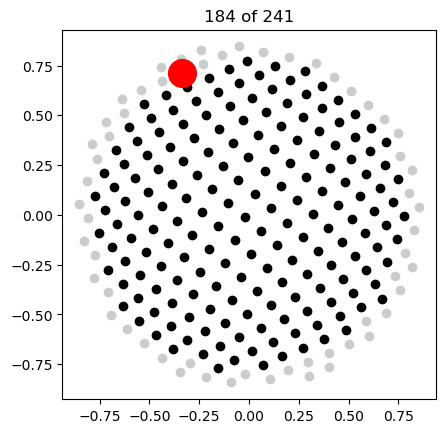

0.6619705212484234 2.0089072672300836
<SkyCoord (AltAz: obstime=2023-03-08 02:41:44.212264, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (115.10190785, 37.92811703)>
<SkyCoord (ICRS): (ra, dec) in deg
    (197.23727466, -36.08312364)>
ra_h:dec_d 13.149147071397:-36.0831661964161
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000278.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000232.fits']
---------------------------------


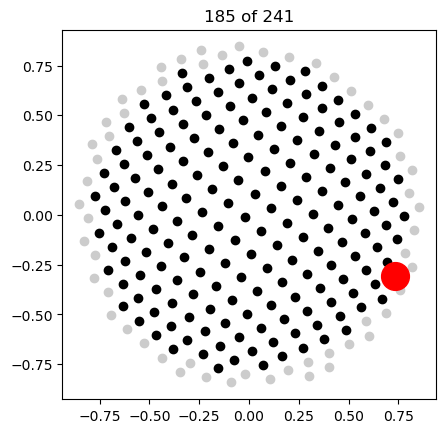

0.6564031768798462 -0.39593628814142023
<SkyCoord (AltAz: obstime=2023-03-08 02:42:09.643842, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (337.31452173, 37.60913169)>
<SkyCoord (ICRS): (ra, dec) in deg
    (116.06643789, 20.13631719)>
ra_h:dec_d 7.73776832328319:20.1363363993707
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000279.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000233.fits']
---------------------------------


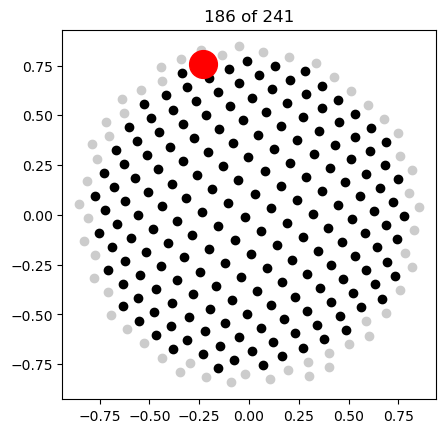

0.6551122385518346 1.868573478262699
<SkyCoord (AltAz: obstime=2023-03-08 02:42:33.990529, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (107.06137401, 37.53516638)>
<SkyCoord (ICRS): (ra, dec) in deg
    (196.18351636, -29.80195935)>
ra_h:dec_d 13.0789074630854:-29.8020774470949
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000280.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000234.fits']
---------------------------------


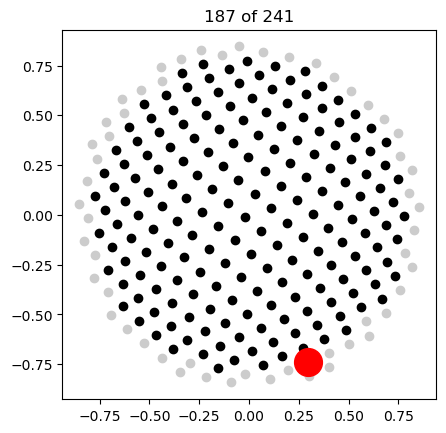

0.6524036878110622 -1.1883759534625344
<SkyCoord (AltAz: obstime=2023-03-08 02:42:59.544313, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (291.91107339, 37.37997785)>
<SkyCoord (ICRS): (ra, dec) in deg
    (87.77419352, -2.01108448)>
ra_h:dec_d 5.85161953473605:-2.01104526307384
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000281.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000235.fits']
---------------------------------


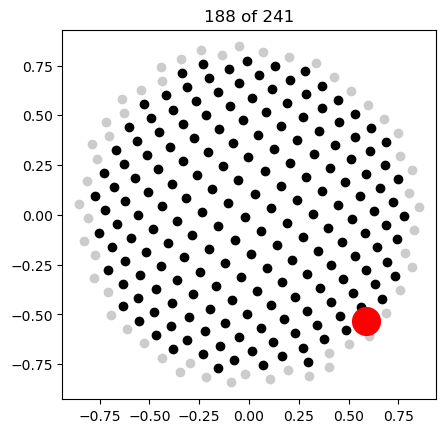

0.6495559828271819 -0.7365389374286484
<SkyCoord (AltAz: obstime=2023-03-08 02:43:25.099801, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (317.79942744, 37.21681637)>
<SkyCoord (ICRS): (ra, dec) in deg
    (102.10185741, 12.89351612)>
ra_h:dec_d 6.80679432821317:12.893574157871
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000282.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000236.fits']
---------------------------------


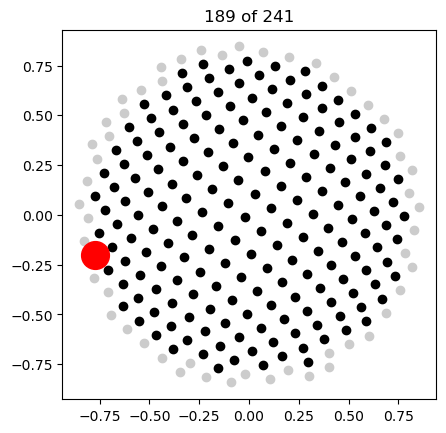

0.6473451732749128 -2.883840296722285
<SkyCoord (AltAz: obstime=2023-03-08 02:43:41.638692, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (194.76812221, 37.09014632)>
<SkyCoord (ICRS): (ra, dec) in deg
    (82.99976123, -75.25400793)>
ra_h:dec_d 5.53331934259769:-75.2540203339089
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000283.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000237.fits']
---------------------------------


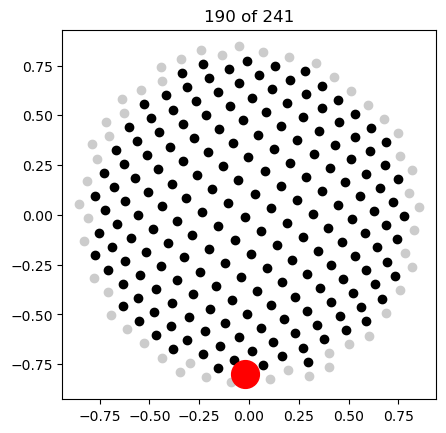

0.6469850406050922 -1.5931221399242363
<SkyCoord (AltAz: obstime=2023-03-08 02:44:03.742858, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (268.72082513, 37.06951223)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.63942326, -17.95264889)>
ra_h:dec_d 5.24262659197161:-17.9526900286071
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000284.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000238.fits']
---------------------------------


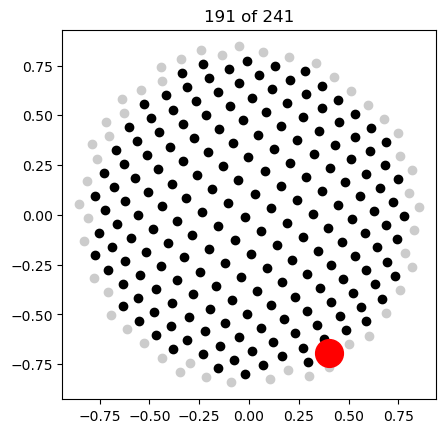

0.6428427030944813 -1.0478685263029608
<SkyCoord (AltAz: obstime=2023-03-08 02:44:23.369395, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (299.96155596, 36.83217378)>
<SkyCoord (ICRS): (ra, dec) in deg
    (91.64766309, 3.38286917)>
ra_h:dec_d 6.10984313390814:3.38291061528979
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000285.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000239.fits']
---------------------------------


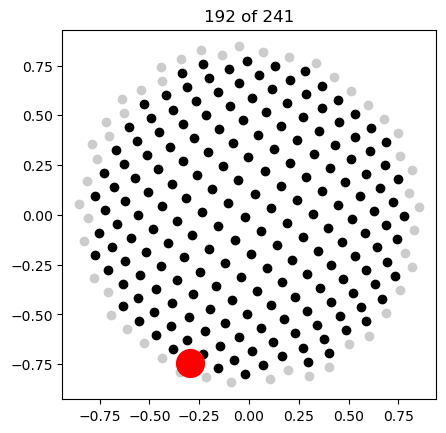

0.641677446556458 -1.9523542286890256
<SkyCoord (AltAz: obstime=2023-03-08 02:44:40.181821, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (248.13834258, 36.7654095)>
<SkyCoord (ICRS): (ra, dec) in deg
    (72.80738378, -33.47731758)>
ra_h:dec_d 4.85382383732518:-33.4772755735819
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000286.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000240.fits']
---------------------------------


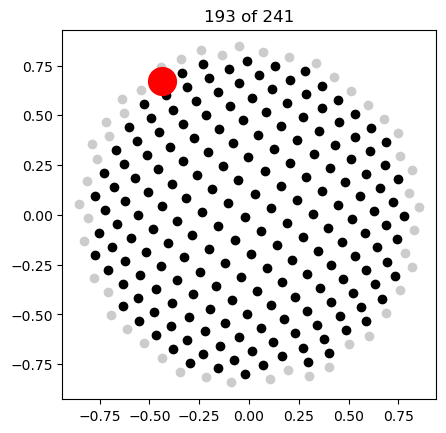

0.6416203826220864 2.1499364639904646
<SkyCoord (AltAz: obstime=2023-03-08 02:44:58.857401, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (123.18228561, 36.76213997)>
<SkyCoord (ICRS): (ra, dec) in deg
    (200.88470158, -42.23042493)>
ra_h:dec_d 13.3923499419641:-42.2302631078834
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000287.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000241.fits']
---------------------------------


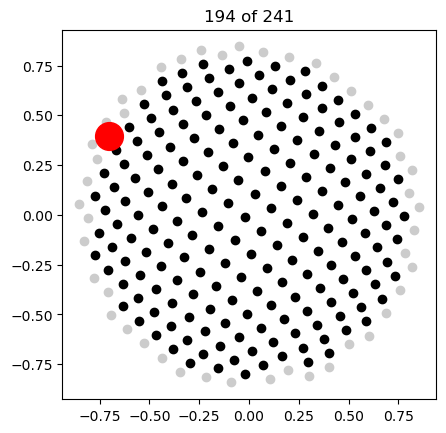

0.6348037566029593 2.625585374123257
<SkyCoord (AltAz: obstime=2023-03-08 02:45:25.325528, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (150.43496069, 36.37157607)>
<SkyCoord (ICRS): (ra, dec) in deg
    (201.54714662, -64.04705648)>
ra_h:dec_d 13.4364909251585:-64.0471164038478
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000288.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000242.fits']
---------------------------------


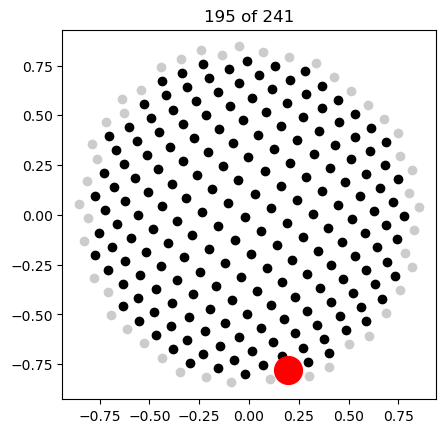

0.6343838638598395 -1.3239470389177366
<SkyCoord (AltAz: obstime=2023-03-08 02:45:41.442937, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (284.14342237, 36.34751799)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.15788782, -6.6295351)>
ra_h:dec_d 5.61053330619153:-6.62951518742461
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000289.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000243.fits']
---------------------------------


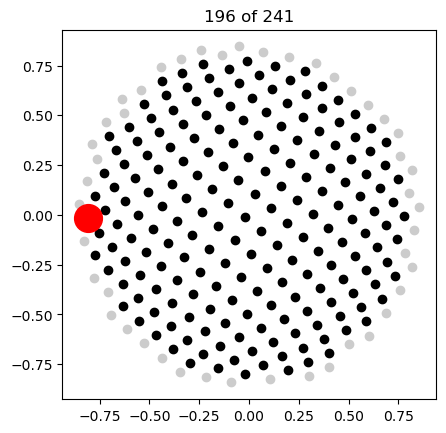

0.6318886360473968 -3.1196222349366978
<SkyCoord (AltAz: obstime=2023-03-08 02:46:05.471485, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (181.25881226, 36.20455197)>
<SkyCoord (ICRS): (ra, dec) in deg
    (128.79452095, -82.63977456)>
ra_h:dec_d 8.58639129460621:-82.6398525460588
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000290.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000244.fits']
---------------------------------


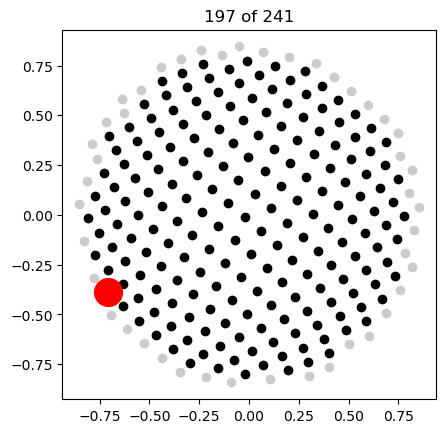

0.6311424763274605 -2.638936255370111
<SkyCoord (AltAz: obstime=2023-03-08 02:46:27.729838, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (208.80009016, 36.16180016)>
<SkyCoord (ICRS): (ra, dec) in deg
    (70.41420287, -64.84411727)>
ra_h:dec_d 4.69428407276275:-64.8441197244364
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000291.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000245.fits']
---------------------------------


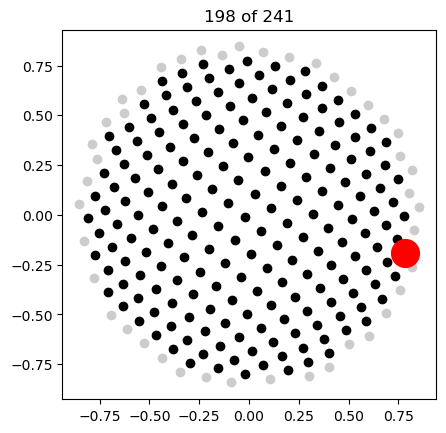

0.6308642138746868 -0.2385654888320747
<SkyCoord (AltAz: obstime=2023-03-08 02:46:46.559847, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (346.33120435, 36.1458569)>
<SkyCoord (ICRS): (ra, dec) in deg
    (124.18353515, 23.66523618)>
ra_h:dec_d 8.27890213371449:23.6652440917572
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000292.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000246.fits']
---------------------------------


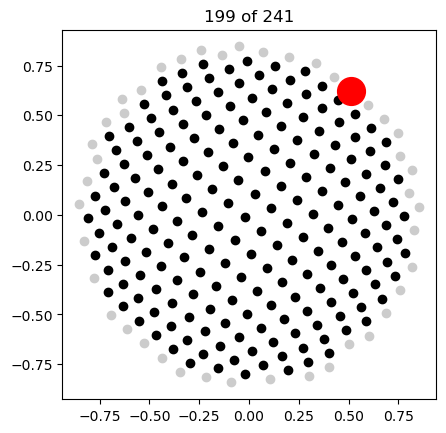

0.6307951710082556 0.8802070306669733
<SkyCoord (AltAz: obstime=2023-03-08 02:47:07.945105, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (50.43214795, 36.14190104)>
<SkyCoord (ICRS): (ra, dec) in deg
    (175.46391959, 9.56508472)>
ra_h:dec_d 11.6975975813827:9.56498274996621
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000293.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000247.fits']
---------------------------------


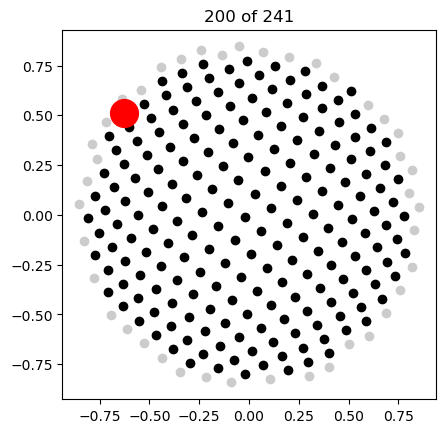

0.6283811492778746 2.456318512839004
<SkyCoord (AltAz: obstime=2023-03-08 02:47:30.464619, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (140.73668393, 36.00358778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (204.0113217, -56.27328511)>
ra_h:dec_d 13.6007564593504:-56.2733832407322
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000294.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000248.fits']
---------------------------------


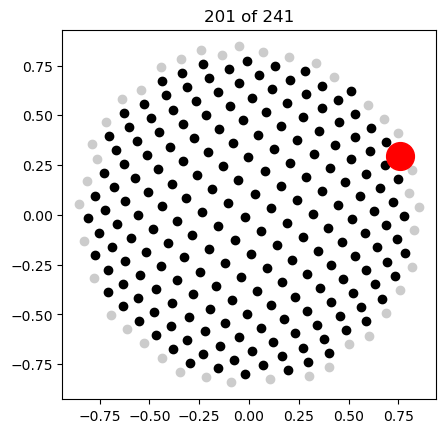

0.6227777835749947 0.3718134501960532
<SkyCoord (AltAz: obstime=2023-03-08 02:47:56.872922, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (21.30334146, 35.68253857)>
<SkyCoord (ICRS): (ra, dec) in deg
    (155.11484005, 22.39132574)>
ra_h:dec_d 10.340988163125:22.391255020707
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000295.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000249.fits']
---------------------------------


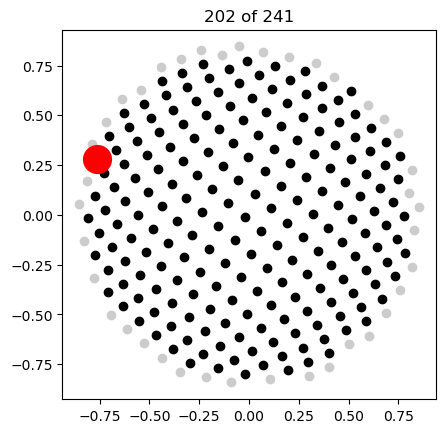

0.6207898997851641 2.786790187726421
<SkyCoord (AltAz: obstime=2023-03-08 02:48:23.426720, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (159.67131615, 35.56864122)>
<SkyCoord (ICRS): (ra, dec) in deg
    (200.33969501, -71.52819308)>
ra_h:dec_d 13.3559783738696:-71.5282260818047
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000296.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000250.fits']
---------------------------------


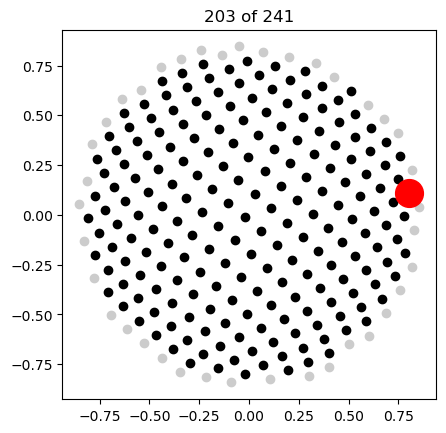

0.6207623576251982 0.13501060251341926
<SkyCoord (AltAz: obstime=2023-03-08 02:48:50.441820, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (7.73553771, 35.56706317)>
<SkyCoord (ICRS): (ra, dec) in deg
    (143.66921948, 25.12288804)>
ra_h:dec_d 9.57794779622921:25.1228142465486
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000297.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000251.fits']
---------------------------------


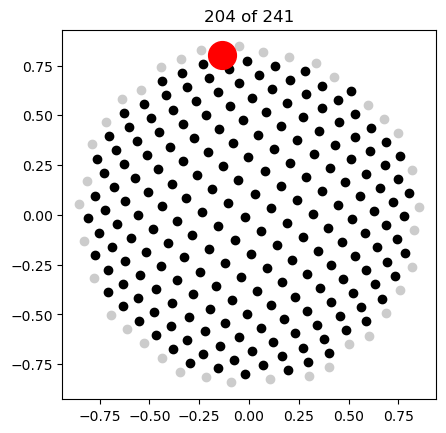

0.6207104806293262 1.7397920226734434
<SkyCoord (AltAz: obstime=2023-03-08 02:49:17.154658, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (99.68274013, 35.56409084)>
<SkyCoord (ICRS): (ra, dec) in deg
    (197.97898016, -23.55891852)>
ra_h:dec_d 13.1986036605925:-23.5590278012048
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000298.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000252.fits']
---------------------------------


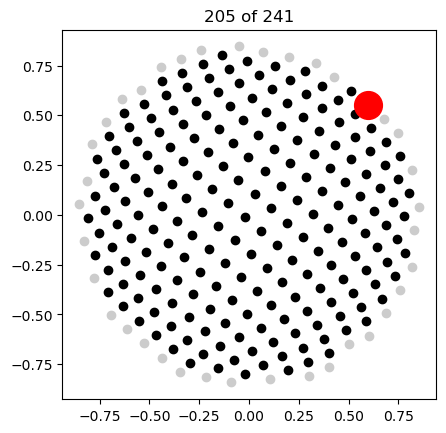

0.6201819471283058 0.744835014256428
<SkyCoord (AltAz: obstime=2023-03-08 02:49:39.271492, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (42.67590275, 35.5338081)>
<SkyCoord (ICRS): (ra, dec) in deg
    (171.60572895, 14.10160621)>
ra_h:dec_d 11.4403809027084:14.1014987574053
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000299.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000253.fits']
---------------------------------


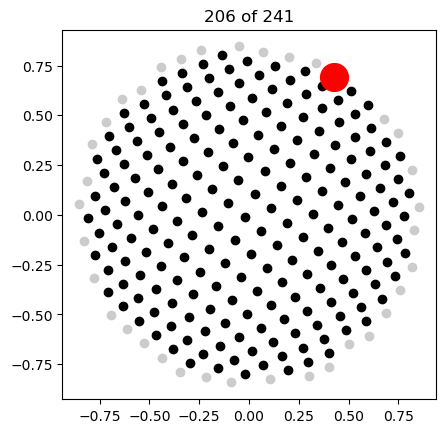

0.6190392473857581 1.0186945009714408
<SkyCoord (AltAz: obstime=2023-03-08 02:49:58.422186, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (58.36689552, 35.46833623)>
<SkyCoord (ICRS): (ra, dec) in deg
    (181.18887805, 5.42308826)>
ra_h:dec_d 12.0792620670822:5.42298639810029
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000300.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000254.fits']
---------------------------------


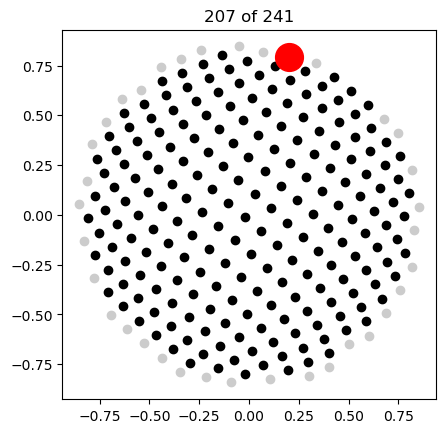

0.6152378033071418 1.3217903859561855
<SkyCoord (AltAz: obstime=2023-03-08 02:50:14.865229, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (75.73301052, 35.25052953)>
<SkyCoord (ICRS): (ra, dec) in deg
    (189.84299085, -5.83103334)>
ra_h:dec_d 12.6561999016177:-5.8311056271938
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000301.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000255.fits']
---------------------------------


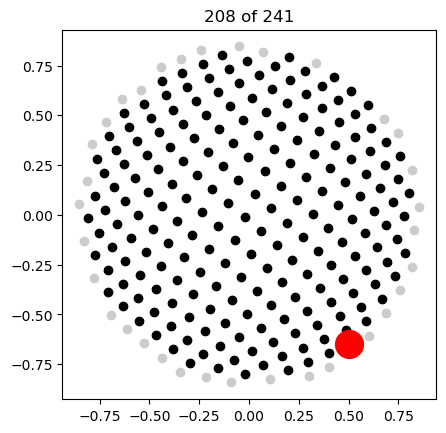

0.607275147886967 -0.9125634284186184
<SkyCoord (AltAz: obstime=2023-03-08 02:50:31.044249, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (307.71396701, 34.79430298)>
<SkyCoord (ICRS): (ra, dec) in deg
    (95.99002262, 9.37502366)>
ra_h:dec_d 6.39934090776559:9.37500592218764
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000302.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000256.fits']
---------------------------------


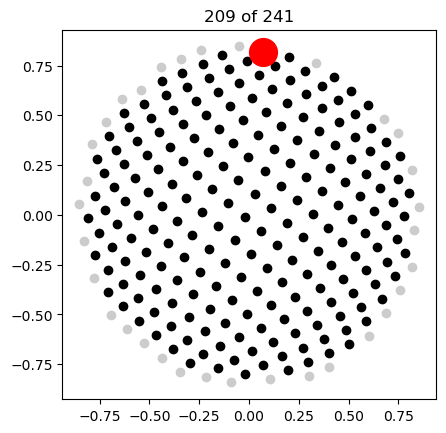

0.6069315170867638 1.4876013360656604
<SkyCoord (AltAz: obstime=2023-03-08 02:50:56.245992, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (85.23327815, 34.77461438)>
<SkyCoord (ICRS): (ra, dec) in deg
    (194.26864851, -12.39751248)>
ra_h:dec_d 12.9512444411077:-12.3975609647047
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000303.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000257.fits']
---------------------------------


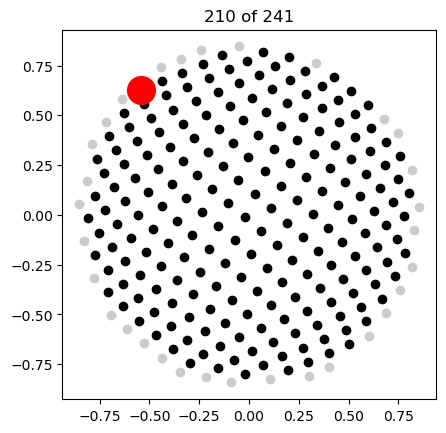

0.5963144409243277 2.2822459782036875
<SkyCoord (AltAz: obstime=2023-03-08 02:51:22.762631, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (130.76306236, 34.16630073)>
<SkyCoord (ICRS): (ra, dec) in deg
    (207.24705148, -48.02753447)>
ra_h:dec_d 13.816464525157:-48.0275770977101
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000304.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000258.fits']
---------------------------------


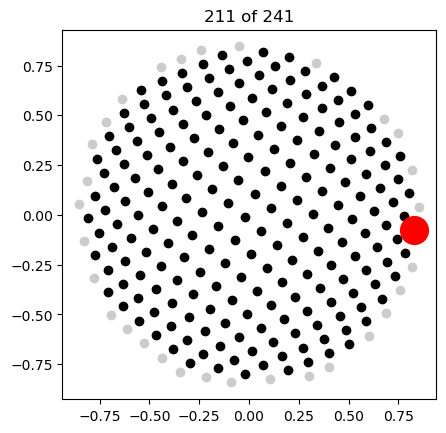

0.5915648294335567 -0.09183339294648643
<SkyCoord (AltAz: obstime=2023-03-08 02:51:49.176014, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (354.73833417, 33.89416803)>
<SkyCoord (ICRS): (ra, dec) in deg
    (132.56738992, 26.99181101)>
ra_h:dec_d 8.83782662568684:26.9917228973275
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000305.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000259.fits']
---------------------------------


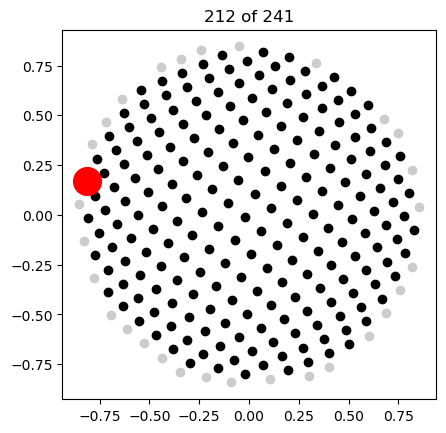

0.5907436558774912 2.938049448178801
<SkyCoord (AltAz: obstime=2023-03-08 02:52:14.014793, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (168.33783338, 33.84711826)>
<SkyCoord (ICRS): (ra, dec) in deg
    (198.47969463, -78.822651)>
ra_h:dec_d 13.2319940218482:-78.8226953752624
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000306.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000260.fits']
---------------------------------


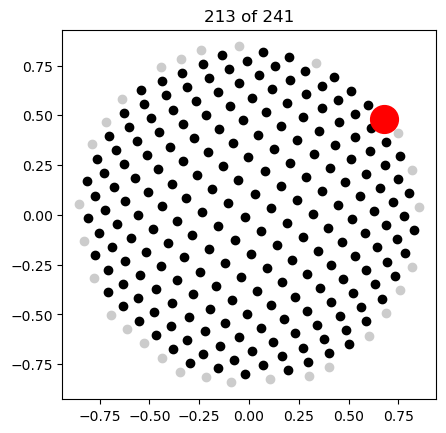

0.5907399142518989 0.6172549098215145
<SkyCoord (AltAz: obstime=2023-03-08 02:52:39.663241, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (35.36610122, 33.84690388)>
<SkyCoord (ICRS): (ra, dec) in deg
    (168.23121391, 18.9280979)>
ra_h:dec_d 11.215415260491:18.9280612184937
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000307.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000261.fits']
---------------------------------


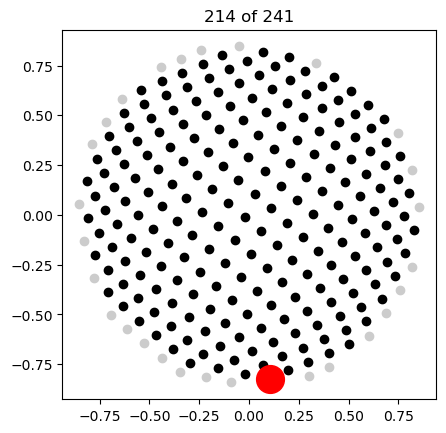

0.5890320919712173 -1.4441307659864024
<SkyCoord (AltAz: obstime=2023-03-08 02:53:07.344614, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (277.25740204, 33.74905287)>
<SkyCoord (ICRS): (ra, dec) in deg
    (80.92377767, -10.24314978)>
ra_h:dec_d 5.39492283225623:-10.2432664411892
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000308.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000262.fits']
---------------------------------


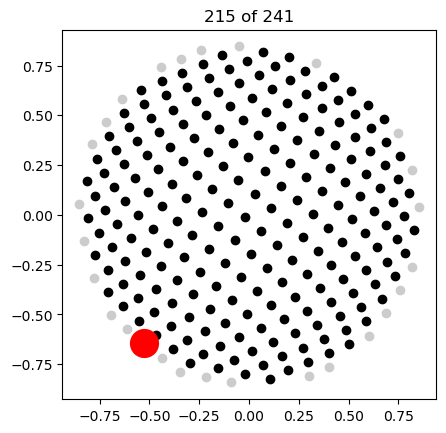

0.5858143703383712 -2.2554738468772433
<SkyCoord (AltAz: obstime=2023-03-08 02:53:30.449777, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (230.77086777, 33.564691)>
<SkyCoord (ICRS): (ra, dec) in deg
    (67.52483473, -46.84429253)>
ra_h:dec_d 4.50165562749056:-46.8442128758113
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000309.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000263.fits']
---------------------------------


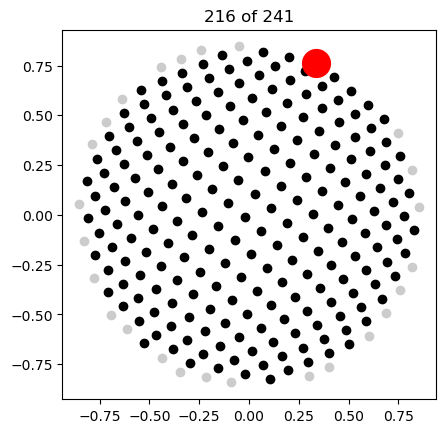

0.5812552259960257 1.1543367255027541
<SkyCoord (AltAz: obstime=2023-03-08 02:53:48.394821, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (66.13862251, 33.30347127)>
<SkyCoord (ICRS): (ra, dec) in deg
    (187.88912754, 1.81800407)>
ra_h:dec_d 12.5259423189628:1.81799511168951
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000310.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000264.fits']
---------------------------------


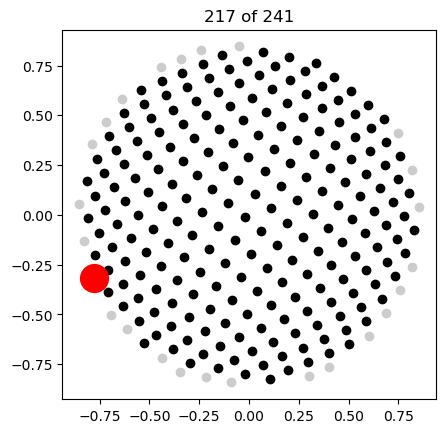

0.5764563324859151 -2.752508238688214
<SkyCoord (AltAz: obstime=2023-03-08 02:54:12.776305, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (202.29289485, 33.02851493)>
<SkyCoord (ICRS): (ra, dec) in deg
    (65.99808685, -70.56306276)>
ra_h:dec_d 4.39987288049569:-70.5631133397273
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000311.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000265.fits']
---------------------------------


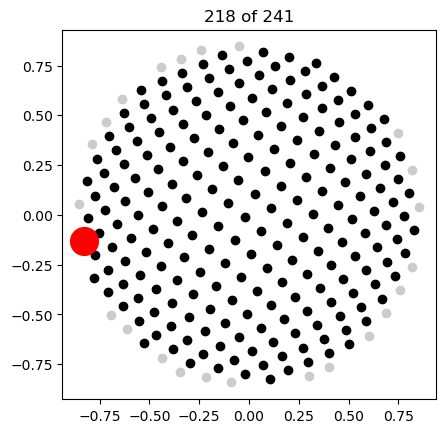

0.5751463868503288 -2.9831090322854203
<SkyCoord (AltAz: obstime=2023-03-08 02:54:34.777953, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (189.08044262, 32.95346057)>
<SkyCoord (ICRS): (ra, dec) in deg
    (78.21346428, -81.29795225)>
ra_h:dec_d 5.21421944629373:-81.2979658251141
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000312.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000266.fits']
---------------------------------


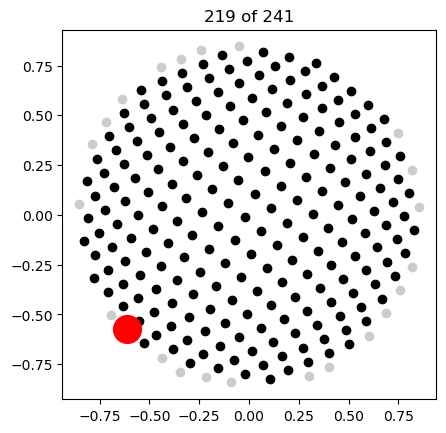

0.5749674625763662 -2.387482817164498
<SkyCoord (AltAz: obstime=2023-03-08 02:54:51.368737, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (223.20731092, 32.94320896)>
<SkyCoord (ICRS): (ra, dec) in deg
    (65.74106221, -53.04972593)>
ra_h:dec_d 4.38275020014043:-53.0496683932331
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000313.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000267.fits']
---------------------------------


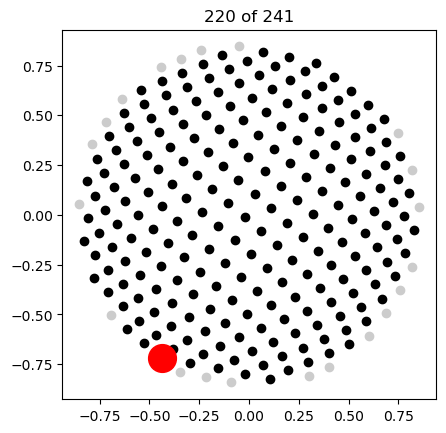

0.5740927203982111 -2.1196129968668576
<SkyCoord (AltAz: obstime=2023-03-08 02:55:09.572201, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (238.55512108, 32.89308993)>
<SkyCoord (ICRS): (ra, dec) in deg
    (68.58605126, -40.31603304)>
ra_h:dec_d 4.57240325211114:-40.3160503603473
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000314.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000268.fits']
---------------------------------


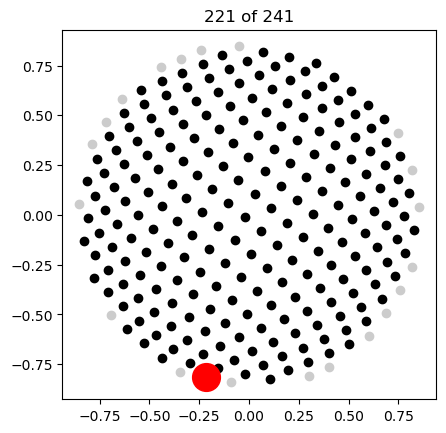

0.5692341765216915 -1.8290068697253168
<SkyCoord (AltAz: obstime=2023-03-08 02:55:24.526554, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (255.20562566, 32.61471587)>
<SkyCoord (ICRS): (ra, dec) in deg
    (72.74374901, -26.74349749)>
ra_h:dec_d 4.84957936274235:-26.7435342543048
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000315.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000269.fits']
---------------------------------


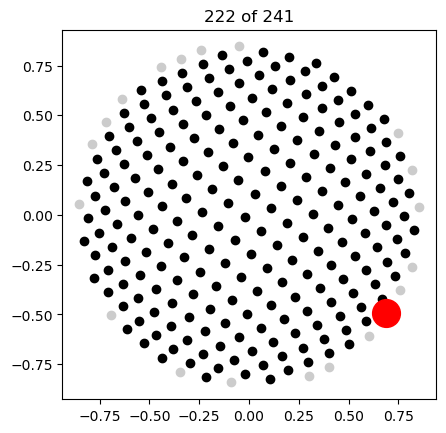

0.5667657395770956 -0.6213857359991737
<SkyCoord (AltAz: obstime=2023-03-08 02:55:40.621787, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (324.39721988, 32.47328485)>
<SkyCoord (ICRS): (ra, dec) in deg
    (106.95952808, 19.88839427)>
ra_h:dec_d 7.13063350496733:19.8884003773601
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000316.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000270.fits']
---------------------------------


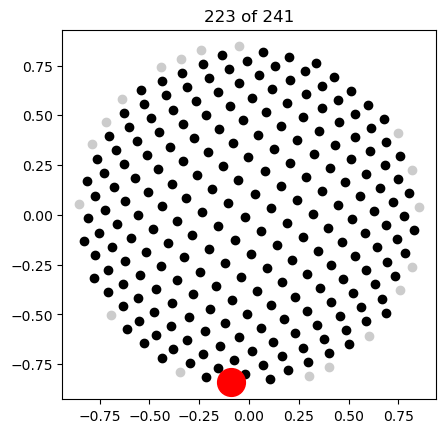

0.5622230300239158 -1.6747869423472257
<SkyCoord (AltAz: obstime=2023-03-08 02:55:59.485940, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (264.04177662, 32.21300677)>
<SkyCoord (ICRS): (ra, dec) in deg
    (75.32941188, -19.61958265)>
ra_h:dec_d 5.02195951826308:-19.6195330407332
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000317.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000271.fits']
---------------------------------


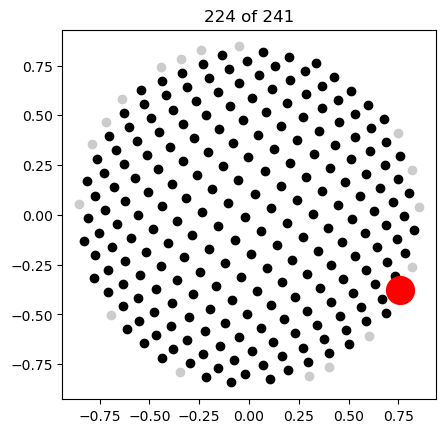

0.5621788226932143 -0.46107023980869594
<SkyCoord (AltAz: obstime=2023-03-08 02:56:17.920073, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (333.5826212, 32.21047387)>
<SkyCoord (ICRS): (ra, dec) in deg
    (114.28174325, 23.89686122)>
ra_h:dec_d 7.61878384144465:23.8968607009933
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000318.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000272.fits']
---------------------------------


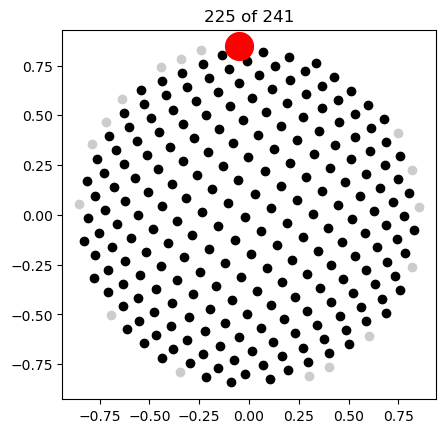

0.5599903352512194 1.6320249408007548
<SkyCoord (AltAz: obstime=2023-03-08 02:56:36.264490, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (93.50814117, 32.08508278)>
<SkyCoord (ICRS): (ra, dec) in deg
    (201.24143318, -17.51010819)>
ra_h:dec_d 13.4161093235722:-17.5101935531645
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000319.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000273.fits']
---------------------------------


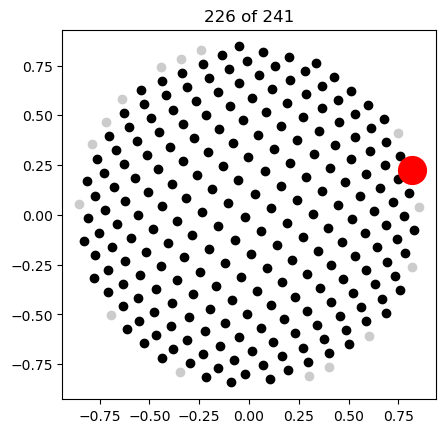

0.5576336495364073 0.2673934188933572
<SkyCoord (AltAz: obstime=2023-03-08 02:57:01.873952, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (15.32051437, 31.95005463)>
<SkyCoord (ICRS): (ra, dec) in deg
    (153.40543855, 27.44740894)>
ra_h:dec_d 10.2270295059784:27.4473545427648
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000320.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000274.fits']
---------------------------------


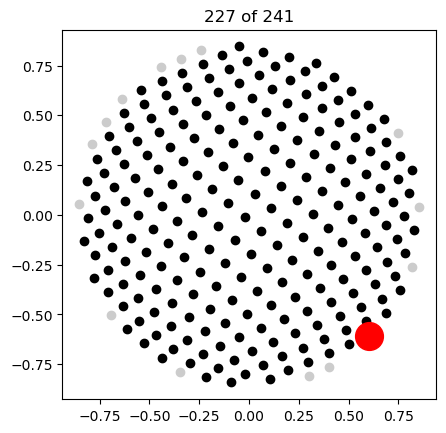

0.54887142002005 -0.7897122364972619
<SkyCoord (AltAz: obstime=2023-03-08 02:57:22.990083, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (314.75282182, 31.44801586)>
<SkyCoord (ICRS): (ra, dec) in deg
    (99.85074072, 15.82491437)>
ra_h:dec_d 6.65671641413844:15.8248494870634
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000321.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000275.fits']
---------------------------------


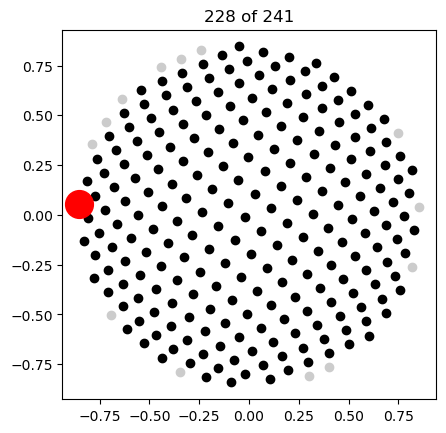

0.5484784120977776 3.079230405138253
<SkyCoord (AltAz: obstime=2023-03-08 02:57:44.460792, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (176.42690636, 31.42549817)>
<SkyCoord (ICRS): (ra, dec) in deg
    (189.64325643, -85.95174405)>
ra_h:dec_d 12.6429785344259:-85.9516924570253
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000322.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000276.fits']
---------------------------------


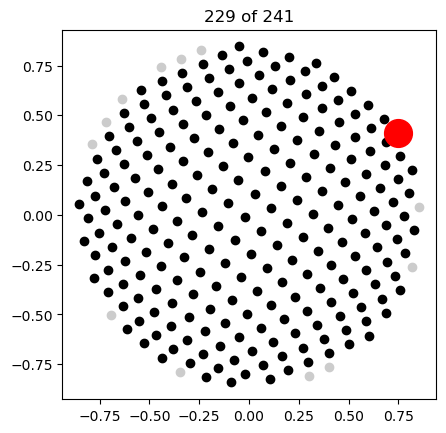

0.5459684434909648 0.500097211334084
<SkyCoord (AltAz: obstime=2023-03-08 02:58:08.448753, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (28.65345956, 31.28168756)>
<SkyCoord (ICRS): (ra, dec) in deg
    (165.69862477, 23.96360332)>
ra_h:dec_d 11.046574860768:23.9635385875752
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000323.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000277.fits']
---------------------------------


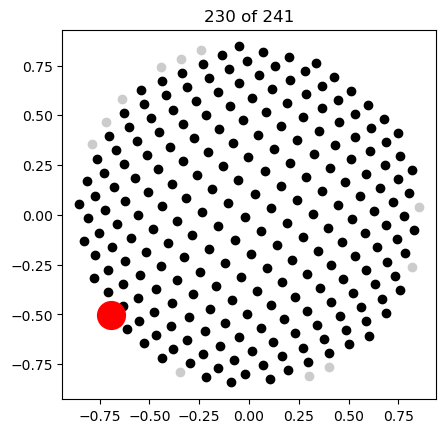

0.5453687710184815 -2.5116381937219354
<SkyCoord (AltAz: obstime=2023-03-08 02:58:36.638398, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.09373184, 31.24732886)>
<SkyCoord (ICRS): (ra, dec) in deg
    (62.67293538, -58.893368)>
ra_h:dec_d 4.17819755545853:-58.893333636066
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000324.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000278.fits']
---------------------------------


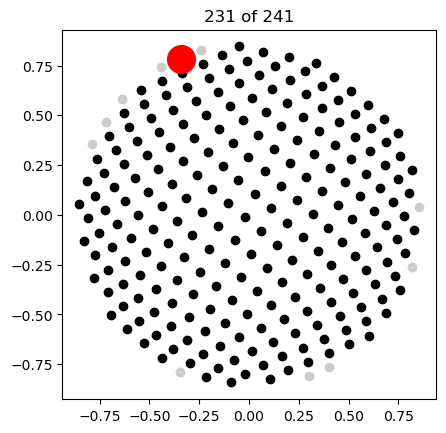

0.544016170059361 1.9794146846575922
<SkyCoord (AltAz: obstime=2023-03-08 02:58:57.917936, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (113.41210734, 31.16983053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (209.13357402, -33.13771539)>
ra_h:dec_d 13.9422688124692:-33.1374609788805
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000325.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000279.fits']
---------------------------------


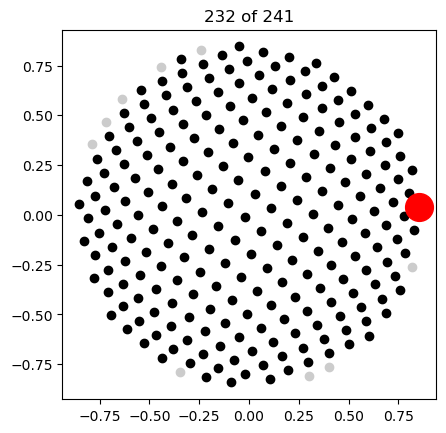

0.5419861245686464 0.04505141556906892
<SkyCoord (AltAz: obstime=2023-03-08 02:59:24.655480, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (2.58125597, 31.05351749)>
<SkyCoord (ICRS): (ra, dec) in deg
    (141.9195103, 29.99350736)>
ra_h:dec_d 9.46129979890047:29.9934241721032
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000326.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000280.fits']
---------------------------------


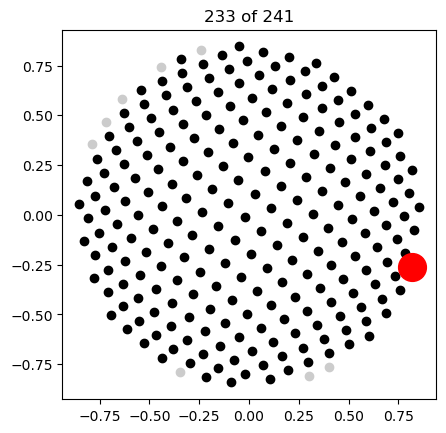

0.5401463100575578 -0.31012547405322727
<SkyCoord (AltAz: obstime=2023-03-08 02:59:49.594359, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (342.23111922, 30.94810389)>
<SkyCoord (ICRS): (ra, dec) in deg
    (122.26788429, 27.77427103)>
ra_h:dec_d 8.15119537626978:27.7742336253977
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000327.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000281.fits']
---------------------------------


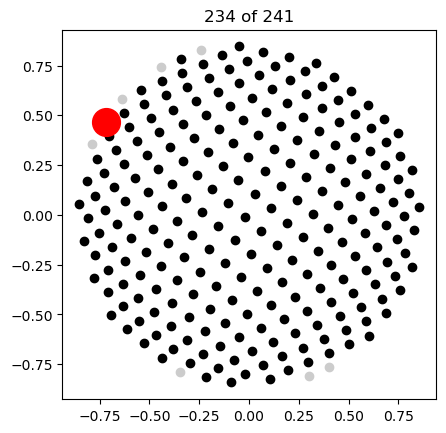

0.5391148685027076 2.5645126798637885
<SkyCoord (AltAz: obstime=2023-03-08 03:00:07.678206, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (146.93575306, 30.88900664)>
<SkyCoord (ICRS): (ra, dec) in deg
    (217.36403856, -61.2917996)>
ra_h:dec_d 8.15119162275802:27.774264165525
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000328.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000282.fits']
---------------------------------


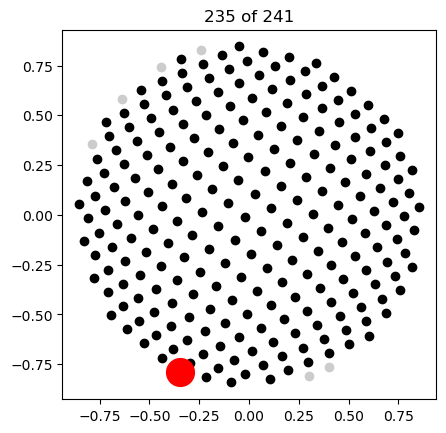

0.5354816316358422 -1.9850535126978353
<SkyCoord (AltAz: obstime=2023-03-08 03:00:17.671090, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (246.26481161, 30.6808375)>
<SkyCoord (ICRS): (ra, dec) in deg
    (69.19764036, -33.4203149)>
ra_h:dec_d 4.61318161547491:-33.4203104567413
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000329.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000283.fits']
---------------------------------


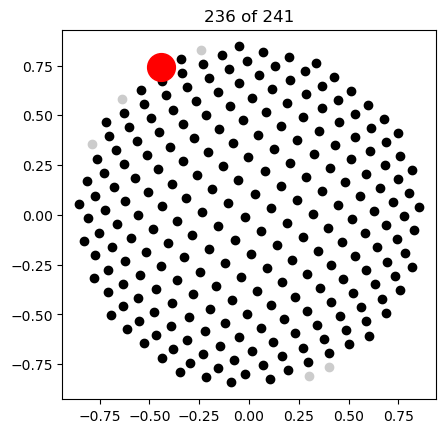

0.5314065150877647 2.106333354244688
<SkyCoord (AltAz: obstime=2023-03-08 03:00:38.736195, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (120.68401145, 30.44735052)>
<SkyCoord (ICRS): (ra, dec) in deg
    (212.44368419, -38.97586448)>
ra_h:dec_d 14.1629174838183:-38.9759383457316
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000330.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000284.fits']
---------------------------------


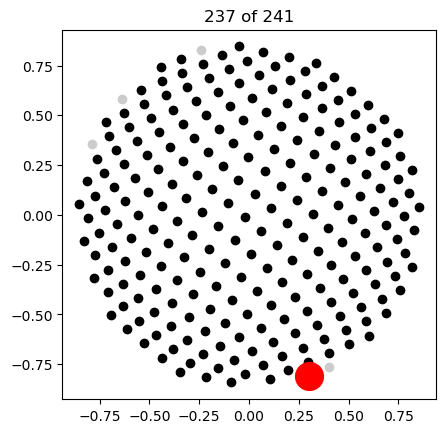

0.5306478843356696 -1.2139088916596723
<SkyCoord (AltAz: obstime=2023-03-08 03:01:06.075863, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (290.44814379, 30.40388418)>
<SkyCoord (ICRS): (ra, dec) in deg
    (85.91432566, 1.03082252)>
ra_h:dec_d 5.72762557270462:1.03081139677852
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000331.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000285.fits']
---------------------------------


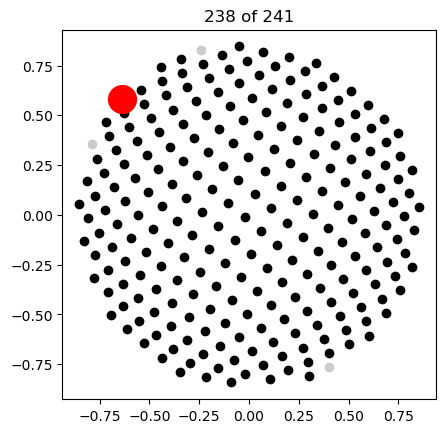

0.5296538498105565 2.4000215596433363
<SkyCoord (AltAz: obstime=2023-03-08 03:01:31.441637, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (137.51110611, 30.3469302)>
<SkyCoord (ICRS): (ra, dec) in deg
    (216.96055944, -53.17541242)>
ra_h:dec_d 14.4640472710229:-53.175472015253
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000332.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000286.fits']
---------------------------------


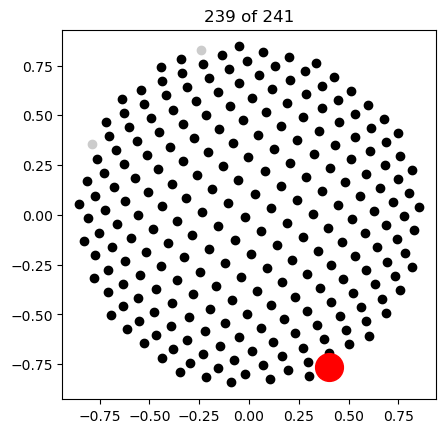

0.5295175168978008 -1.0878341540105976
<SkyCoord (AltAz: obstime=2023-03-08 03:01:57.158065, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (297.67169417, 30.3391189)>
<SkyCoord (ICRS): (ra, dec) in deg
    (89.81127001, 6.06287117)>
ra_h:dec_d 5.98742536629408:6.06291203524083
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000333.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000287.fits']
---------------------------------


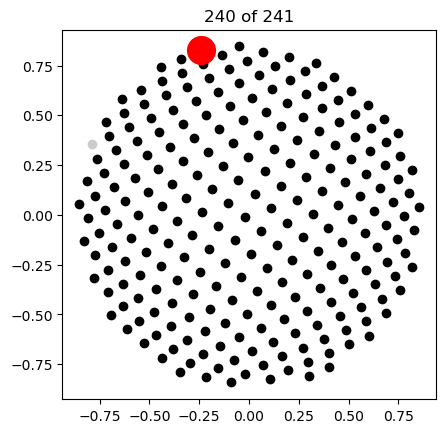

0.5284660301460635 1.8547960565626433
<SkyCoord (AltAz: obstime=2023-03-08 03:02:21.478171, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (106.2719859, 30.27887314)>
<SkyCoord (ICRS): (ra, dec) in deg
    (208.79789271, -27.02232945)>
ra_h:dec_d 13.9198657120406:-27.0223716410293
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000334.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000288.fits']
---------------------------------


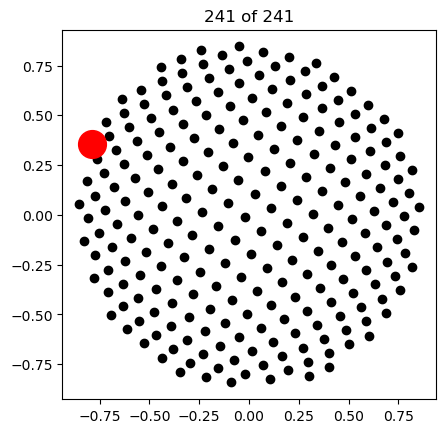

0.5280985884820611 2.7199649372001136
<SkyCoord (AltAz: obstime=2023-03-08 03:02:47.654822, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (155.84251133, 30.25782029)>
<SkyCoord (ICRS): (ra, dec) in deg
    (220.63906357, -68.90857164)>
ra_h:dec_d 14.7092827431782:-68.908611411675
['/data/lvm/skyw/agcam/east/20230308/lvm.skyw.agcam.east_00000335.fits', '/data/lvm/skyw/agcam/west/20230308/lvm.skyw.agcam.west_00000289.fits']
---------------------------------


In [18]:
show_2d_plot = True


start_from = 98


for index in range(len(alt)):
    if index<start_from -1:
        continue
    current_alt = alt[index]
    current_az = az[index]
    if show_2d_plot:
        fig,ax = plt.subplots()
        ax.set_aspect("equal")
        ax.plot(x[:index],y[:index],"ko")
        ax.plot(x[index:],y[index:],"o",color="0.8")
        ax.plot(x[index],y[index],"ro",ms=20)
        ax.set_title("{} of {}".format(index+1,len(alt)))
        plt.show()

    print(current_alt,current_az)
    
    
    observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
    observing_time = Time.now()
    
    await tel.km.slewStop()
    
    current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
    current_icrs = current_aa.transform_to(ICRS)
    print(current_aa)
    print(current_icrs)
    
    rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
    ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
    print(f"ra_h:dec_d {ra_h}:{dec_d}")

    # dont do that on every exposure if you didn't change the pointing

    await tel.km.slewStart(ra_h, dec_d)
    
    #input("Telescope slewing done... proceed?")
    
    rc = await tel.agc.expose(7.)
    filenames = rc.flatten().unpack("*.filename")
    print(filenames)
    print("---------------------------------")

In [34]:
await tel.km.slewStop() # has to be done, otherwise k-mirror will rotate until it hits a limit
await tel.km.moveAbsolute(90., "DEG") # parking position (all mirror surfaces vertical)
await tel.pwi.park() # goto park position
await tel.pwi.setEnabled(False) # disengage motors (telescope should be free floating now)

{'is_enabled': False,
 'axis0': {'is_enabled': False},
 'axis1': {'is_enabled': False}}